# MITRE ATT&CK: Applied Analysis & Detection Engineering

## 🎯 Learning Objectives
By the end of this notebook, you will be able to:
- Map real-world cyber attacks to the ATT&CK framework
- Identify detection opportunities at each stage of an attack
- Design and write detection rules for specific techniques
- Assess your organization's detection coverage using ATT&CK
- Plan and execute purple team exercises based on threat intelligence

## 📚 What Makes This Notebook Different?
In **Notebook 2**, you learned to *analyze* ATT&CK data programmatically. Now we're applying that knowledge to:
- **Real Attack Scenarios:** Reconstruct actual breaches (WannaCry, APT29)
- **Detection Engineering:** Write rules that catch attackers
- **Coverage Analysis:** Identify blind spots in your defenses
- **Purple Teaming:** Test whether your detections actually work

## 🎓 Prerequisites
- Completion of Notebooks 01 and 02
- Understanding of ATT&CK tactics and techniques
- Basic knowledge of security monitoring concepts (SIEM, EDR, logs)
- Familiarity with the Cyber Kill Chain

## 💼 Real-World Relevance
**Who uses these skills?**
- **SOC Analysts:** Investigate alerts using ATT&CK context
- **Detection Engineers:** Build SIEM rules based on TTPs
- **Threat Hunters:** Proactively search for TTPs in your environment
- **Incident Responders:** Reconstruct attacks using ATT&CK mapping
- **Purple Team Leads:** Design realistic adversary simulations

---

## Setup: Load Libraries and Data

**What we're doing:** Setting up our analysis environment with the same libraries from Notebook 2, plus some new ones for timeline visualization.

In [ ]:
# ============================================================================
# STEP 1: Import Required Libraries
# ============================================================================
# Purpose: Load all Python libraries needed for attack analysis and detection

import pandas as pd                    # Data tables and analysis
import matplotlib.pyplot as plt        # Visualizations
import seaborn as sns                  # Enhanced charts
import networkx as nx                  # Graph analysis (for attack chains)
from stix2 import MemoryStore, Filter  # ATT&CK data handling
import requests                        # Download ATT&CK data
import json                            # Parse JSON
from collections import Counter, defaultdict  # Data organization
from datetime import datetime          # Timestamps for detection rules
import warnings
warnings.filterwarnings('ignore')      # Hide unnecessary warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')  # Professional chart style
sns.set_palette("Set2")                  # Accessible color palette
%matplotlib inline                       # Display charts in notebook

print("✓ Libraries imported successfully!")
print("  Ready for applied ATT&CK analysis!")

✓ Libraries imported!


In [ ]:
# ============================================================================
# STEP 2: Load ATT&CK Data
# ============================================================================
# Purpose: Download the latest ATT&CK Enterprise matrix
# Note: This is the same function from Notebook 2 - reused for consistency

def load_attack_data():
    """
    Load ATT&CK Enterprise data from MITRE's official repository
    
    Returns:
        attack_store: Queryable database of ATT&CK objects
    """
    print("📥 Loading ATT&CK Enterprise data from MITRE...")
    url = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"
    
    response = requests.get(url)
    attack_data = response.json()
    attack_store = MemoryStore(stix_data=attack_data["objects"])
    
    print(f"✓ Successfully loaded {len(attack_data['objects'])} ATT&CK objects")
    print(f"   Ready to analyze real-world attacks!")
    
    return attack_store

# Load the data
attack = load_attack_data()

Loading ATT&CK data...
✓ Loaded 24771 objects
✓ Loaded 24771 objects


---

## Part 1: Case Study - WannaCry Ransomware Attack

### 📖 Background Story:

**WannaCry** was a devastating global ransomware attack that occurred in **May 2017**. It became one of the most significant cyberattacks in history.

**The Numbers:**
- 🌍 **200,000+ computers** infected across **150 countries**
- 💰 **$4 billion** in estimated global damages
- 🏥 Critical infrastructure hit: NHS (UK healthcare), FedEx, Telefónica, universities

**What Made It Special:**
- **Self-propagating worm:** Spread automatically between computers
- **EternalBlue exploit:** Used NSA-leaked exploit for Windows SMB vulnerability (CVE-2017-0144)
- **Kill switch:** Researcher accidentally stopped it by registering a domain name
- **Rapid spread:** Infected 230,000 computers in a single day

**Why Study WannaCry?**
1. **Clear attack phases:** Shows classic Kill Chain progression
2. **Multiple detection points:** Had many opportunities to detect/stop it
3. **Defense lessons:** Organizations with good security practices were protected
4. **Realistic scenario:** Demonstrates how ransomware actually operates

---

### 🎓 Learning Goals for This Case Study:
- Map a real attack to both Cyber Kill Chain AND ATT&CK
- Identify where detection was possible (and where it failed)
- Understand the relationship between Kill Chain phases and ATT&CK tactics
- Learn which defenses would have stopped the attack

---

### 🔍 The Attack Reconstruction:

Let's break down WannaCry's attack chain step-by-step, mapping each phase to:
1. **Cyber Kill Chain phase** (strategic view)
2. **ATT&CK tactic & technique** (tactical/technical view)
3. **Detection difficulty** (how hard it was to catch)
4. **Detection methods** (what could have stopped it)

In [ ]:
# ============================================================================
# WANNACRY ATTACK CHAIN MAPPING
# ============================================================================
# Purpose: Reconstruct WannaCry's attack using Kill Chain + ATT&CK framework
#
# Why create this mapping?
# - Understand attacker progression through phases
# - Identify where detection was possible (and where it wasn't)
# - Learn which defenses would have been effective
# - Train analysts to think in terms of attack chains

# Each entry represents one phase of the attack
wannacry_mapping = [
    {
        'Kill_Chain_Phase': 'Reconnaissance',
        'Description': 'Scanning for systems with SMB exposed to internet',
        'ATT&CK_Tactic': 'reconnaissance',
        'ATT&CK_Technique': 'T1595.002',
        'Technique_Name': 'Active Scanning: Vulnerability Scanning',
        'Detection_Difficulty': 'Medium',
        'Detection_Methods': ['Network flow analysis', 'Firewall logs', 'IDS signatures'],
        'Real_World_Note': 'Mass scanning of port 445 was detectable but commonly ignored'
    },
    {
        'Kill_Chain_Phase': 'Weaponization',
        'Description': 'EternalBlue exploit packaged with DoublePulsar backdoor',
        'ATT&CK_Tactic': 'resource-development',
        'ATT&CK_Technique': 'T1588.006',
        'Technique_Name': 'Obtain Capabilities: Vulnerabilities',
        'Detection_Difficulty': 'Very Hard',
        'Detection_Methods': ['Threat intelligence', 'Dark web monitoring'],
        'Real_World_Note': 'Happened before the attack - attackers assembled tools offline'
    },
    {
        'Kill_Chain_Phase': 'Delivery',
        'Description': 'Exploit delivered via SMB protocol (port 445)',
        'ATT&CK_Tactic': 'initial-access',
        'ATT&CK_Technique': 'T1190',
        'Technique_Name': 'Exploit Public-Facing Application',
        'Detection_Difficulty': 'Medium',
        'Detection_Methods': ['SMB traffic monitoring', 'Vulnerability scanning', 'Network IDS'],
        'Real_World_Note': 'Organizations with updated patches were immune'
    },
    {
        'Kill_Chain_Phase': 'Exploitation',
        'Description': 'EternalBlue exploits SMB buffer overflow',
        'ATT&CK_Tactic': 'execution',
        'ATT&CK_Technique': 'T1203',
        'Technique_Name': 'Exploitation for Client Execution',
        'Detection_Difficulty': 'Hard',
        'Detection_Methods': ['Memory forensics', 'Endpoint behavior monitoring'],
        'Real_World_Note': 'Exploitation happens in milliseconds - very hard to catch in real-time'
    },
    {
        'Kill_Chain_Phase': 'Installation',
        'Description': 'DoublePulsar backdoor installed, ransomware payload dropped',
        'ATT&CK_Tactic': 'persistence',
        'ATT&CK_Technique': 'T1543.003',
        'Technique_Name': 'Create or Modify System Process: Windows Service',
        'Detection_Difficulty': 'Easy',
        'Detection_Methods': ['Service creation monitoring', 'File integrity monitoring', 'EDR alerts'],
        'Real_World_Note': 'This was a GREAT detection point - new service + suspicious file'
    },
    {
        'Kill_Chain_Phase': 'Command and Control',
        'Description': 'Limited C2 (kill switch domain check)',
        'ATT&CK_Tactic': 'command-and-control',
        'ATT&CK_Technique': 'T1071.001',
        'Technique_Name': 'Application Layer Protocol: Web Protocols',
        'Detection_Difficulty': 'Easy',
        'Detection_Methods': ['DNS monitoring', 'Web proxy logs', 'Threat intel feeds'],
        'Real_World_Note': 'The kill switch domain check was visible and blockable'
    },
    {
        'Kill_Chain_Phase': 'Lateral Movement',
        'Description': 'Self-propagation via SMB to adjacent systems',
        'ATT&CK_Tactic': 'lateral-movement',
        'ATT&CK_Technique': 'T1210',
        'Technique_Name': 'Exploitation of Remote Services',
        'Detection_Difficulty': 'Medium',
        'Detection_Methods': ['East-west traffic monitoring', 'SMB logging', 'Anomalous connection patterns'],
        'Real_World_Note': 'Worm behavior creates distinctive network patterns'
    },
    {
        'Kill_Chain_Phase': 'Actions on Objectives',
        'Description': 'File encryption and ransom demand',
        'ATT&CK_Tactic': 'impact',
        'ATT&CK_Technique': 'T1486',
        'Technique_Name': 'Data Encrypted for Impact',
        'Detection_Difficulty': 'Easy',
        'Detection_Methods': ['File system monitoring', 'High I/O alerts', 'Extension changes', 'Ransom note detection'],
        'Real_World_Note': 'By this point, damage is done - detection is damage control'
    }
]

# Convert to DataFrame for easy analysis
wannacry_df = pd.DataFrame(wannacry_mapping)

# Display the attack chain
print("\n" + "="*80)
print("🔴 WANNACRY ATTACK RECONSTRUCTION")
print("="*80)
print("\nComplete attack chain with detection opportunities:\n")

# Show key columns in table format
display_df = wannacry_df[['Kill_Chain_Phase', 'ATT&CK_Technique', 'Technique_Name', 'Detection_Difficulty']]
print(display_df.to_string(index=False))

print("\n" + "="*80)
print("💡 KEY OBSERVATION:")
print("   Notice how detection difficulty varies across phases!")
print("   • EARLY phases (Reconnaissance, Weaponization): Hard to detect")
print("   • MIDDLE phases (Installation, C2): Easier to detect") 
print("   • LATE phases (Impact): Easy but too late")
print("\n   LESSON: Focus detection on middle phases for best results!")
print("="*80)


🔴 WannaCry Attack Reconstruction:

     Kill_Chain_Phase ATT&CK_Technique                                   Technique_Name Detection_Difficulty
       Reconnaissance        T1595.002          Active Scanning: Vulnerability Scanning               Medium
        Weaponization        T1588.006             Obtain Capabilities: Vulnerabilities            Very Hard
             Delivery            T1190                Exploit Public-Facing Application               Medium
         Exploitation            T1203                Exploitation for Client Execution                 Hard
         Installation        T1543.003 Create or Modify System Process: Windows Service                 Easy
  Command and Control        T1071.001        Application Layer Protocol: Web Protocols                 Easy
     Lateral Movement            T1210                  Exploitation of Remote Services               Medium
Actions on Objectives            T1486                        Data Encrypted for Impact     

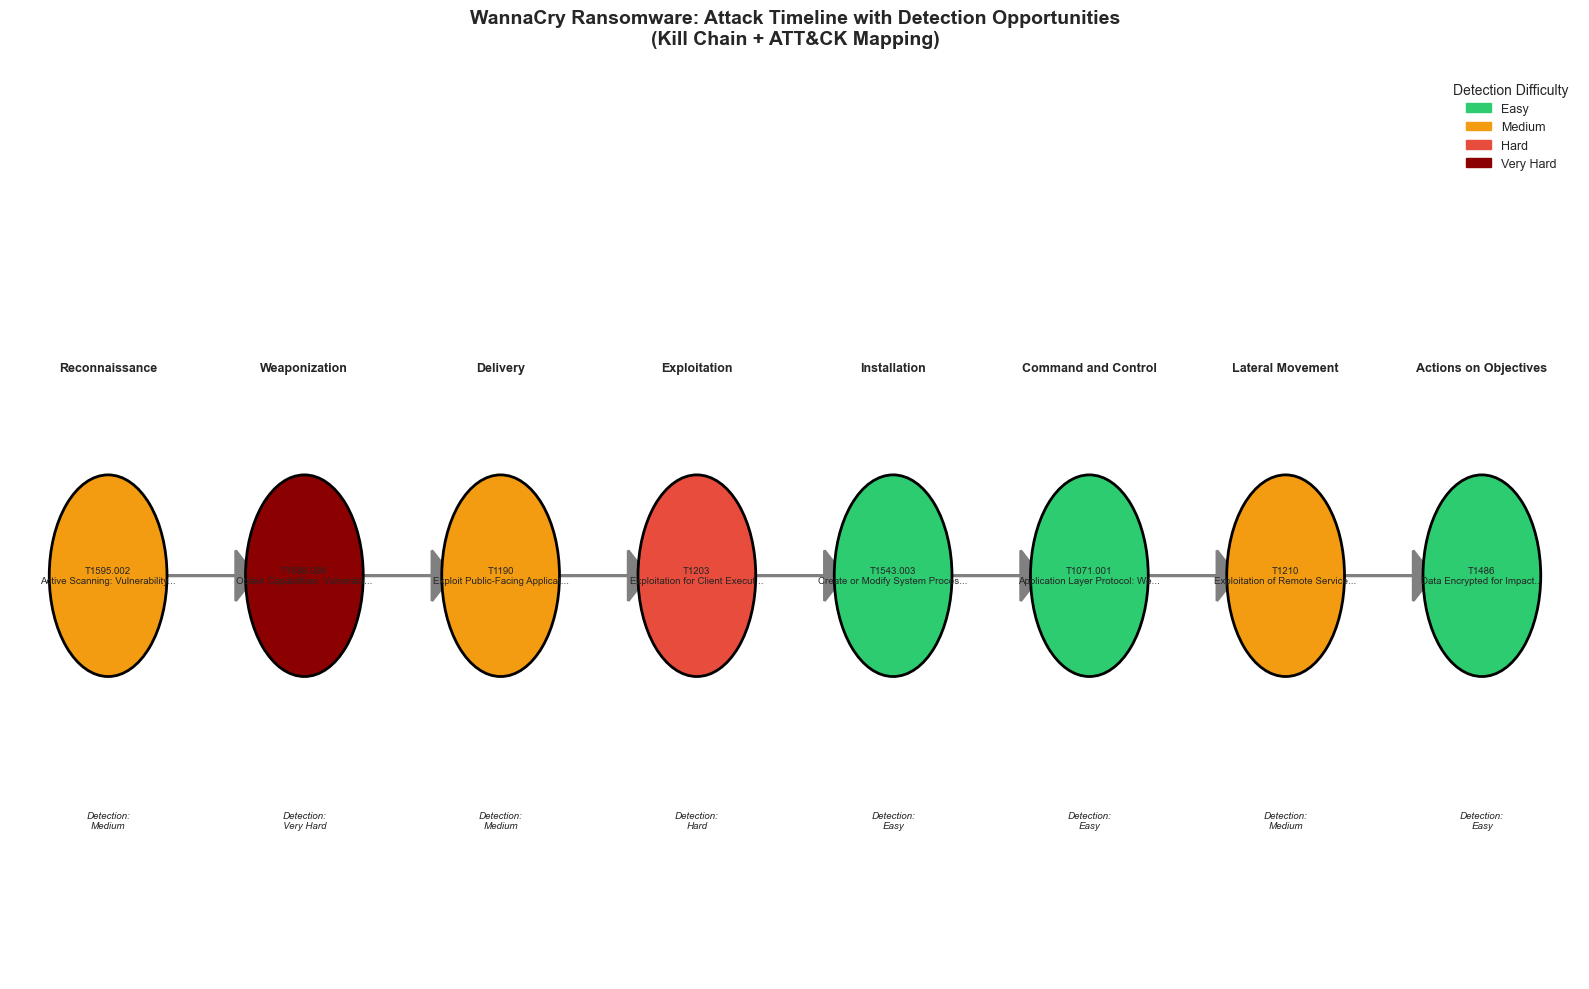

In [ ]:
# ============================================================================
# VISUALIZE WANNACRY ATTACK TIMELINE
# ============================================================================
# Purpose: Create a visual timeline showing attack progression and detection opportunities
#
# Why visualize?
# - Makes complex attack chains understandable at a glance
# - Helps communicate to non-technical stakeholders
# - Identifies detection "windows of opportunity"
# - Training material for SOC analysts

print("📊 Creating visual timeline of WannaCry attack...\n")

fig, ax = plt.subplots(figsize=(16, 10))

# -----------------------------------------------------------------------
# Define color scheme based on detection difficulty
# -----------------------------------------------------------------------
# Green = Easy to detect (good detection opportunity)
# Yellow = Medium difficulty (requires good monitoring)
# Red = Hard to detect (limited detection opportunity)
# Dark Red = Very hard (nearly impossible to detect)

colors_map = {
    'Easy': '#2ecc71',       # Green - good detection point
    'Medium': '#f39c12',     # Orange - moderate difficulty
    'Hard': '#e74c3c',       # Red - difficult
    'Very Hard': '#8b0000'   # Dark red - very difficult
}

colors = [colors_map[diff] for diff in wannacry_df['Detection_Difficulty']]

# -----------------------------------------------------------------------
# Draw the timeline
# -----------------------------------------------------------------------
y_positions = list(range(len(wannacry_df)))

for i, (idx, row) in enumerate(wannacry_df.iterrows()):
    # Draw circle for each event (colored by detection difficulty)
    circle = plt.Circle((i, 2), 0.3, color=colors[i], ec='black', linewidth=2, zorder=3)
    ax.add_patch(circle)
    
    # Label 1: Kill Chain Phase (top)
    ax.text(i, 2.6, row['Kill_Chain_Phase'], ha='center', va='bottom', 
            fontsize=9, fontweight='bold', rotation=0)
    
    # Label 2: ATT&CK Technique (middle, inside circle area)
    technique_label = f"{row['ATT&CK_Technique']}\n{row['Technique_Name'][:30]}..."
    ax.text(i, 2, technique_label, ha='center', va='center', fontsize=7)
    
    # Label 3: Detection Difficulty (bottom)
    ax.text(i, 1.3, f"Detection:\n{row['Detection_Difficulty']}", 
            ha='center', va='top', fontsize=7, style='italic')
    
    # Draw arrow connecting to next phase
    if i < len(wannacry_df) - 1:
        ax.arrow(i + 0.3, 2, 0.35, 0, head_width=0.15, head_length=0.1,
                fc='gray', ec='gray', linewidth=2, zorder=2)

# -----------------------------------------------------------------------
# Formatting
# -----------------------------------------------------------------------
ax.set_xlim(-0.5, len(wannacry_df) - 0.5)
ax.set_ylim(0.8, 3.5)
ax.axis('off')  # Hide axes for cleaner look
ax.set_title('WannaCry Ransomware: Attack Timeline with Detection Opportunities\n' + 
             '(Kill Chain + ATT&CK Mapping)\n\n' +
             'Color = Detection Difficulty | Green = Easy | Yellow = Medium | Red = Hard | Dark Red = Very Hard', 
             fontsize=14, fontweight='bold', pad=20)

# Add legend
legend_elements = [plt.Circle((0, 0), 0.1, color=color, label=diff, ec='black', linewidth=1) 
                  for diff, color in colors_map.items()]
ax.legend(handles=legend_elements, loc='upper right', title='Detection Difficulty', 
         fontsize=9, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# Interpretation Guide
# -----------------------------------------------------------------------
print("\n💡 HOW TO READ THIS TIMELINE:")
print("="*80)
print("1. ARROWS show attack progression (left to right, chronological)")
print("2. COLORS indicate detection difficulty:")
print("   • Green circles = BEST detection opportunities")
print("   • Yellow circles = Moderate - need good monitoring")
print("   • Red circles = Hard - requires advanced capabilities")
print("   • Dark red = Very hard - nearly impossible")
print("\n3. Each circle shows:")
print("   • TOP: Kill Chain phase (strategic view)")
print("   • MIDDLE: ATT&CK technique ID + name (tactical view)")
print("   • BOTTOM: Detection difficulty rating")
print("="*80)

---

### 🛡️ WannaCry Detection Analysis

**Critical Question:** *Where could we have stopped WannaCry?*

Let's analyze each phase to understand detection opportunities and why some organizations were hit while others were protected.

**What we're looking for:**
- Which phases had the BEST detection opportunities?
- What specific security controls would have helped?
- Why did some organizations get infected while others didn't?

**Key Concept: Defense-in-Depth**
You don't need to detect at EVERY phase - you just need to catch it at ONE phase. Multiple detection layers increase your chances.

In [ ]:
# ============================================================================
# DETECTION OPPORTUNITY ANALYSIS
# ============================================================================
# Purpose: For each attack phase, identify what security controls could detect it
#
# Why this matters:
# - Helps prioritize security investments
# - Shows where gaps existed in victim organizations
# - Demonstrates defense-in-depth principle
# - Provides lessons for preventing similar attacks

print("\n" + "="*80)
print("🛡️ WANNACRY DETECTION OPPORTUNITY ANALYSIS")
print("="*80)
print("\nDetailed breakdown of detection methods at each phase:\n")

# Loop through each phase and display detection details
for idx, row in wannacry_df.iterrows():
    print(f"\n{'─'*80}")
    print(f"Phase {idx + 1}: {row['Kill_Chain_Phase']} → {row['Technique_Name']}")
    print(f"{'─'*80}")
    print(f"📍 What happened: {row['Description']}")
    print(f"🎯 ATT&CK Technique: {row['ATT&CK_Technique']}")
    print(f"📊 Detection Difficulty: {row['Detection_Difficulty']}")
    
    print(f"\n🛡️  Detection Methods (What could catch this):")
    for method in row['Detection_Methods']:
        print(f"    • {method}")
    
    print(f"\n💬 Real-World Note:")
    print(f"    {row['Real_World_Note']}")

# -----------------------------------------------------------------------
# Strategic Insights
# -----------------------------------------------------------------------
print("\n\n" + "="*80)
print("🎯 STRATEGIC INSIGHTS & LESSONS LEARNED")
print("="*80)

print("\n1. 🏆 BEST DETECTION POINTS (Easy difficulty):")
print("   ├─ Installation Phase (T1543.003):")
print("   │  └─ New service creation + suspicious file = HIGH confidence alert")
print("   ├─ Command & Control (T1071.001):")
print("   │  └─ Kill switch domain was a unique IOC (Indicator of Compromise)")
print("   └─ Actions on Objectives (T1486):")
print("      └─ Mass file encryption is unmistakable (but damage is done)")

print("\n2. 🔑 CRITICAL PREVENTION POINT:")
print("   ├─ The MS17-010 patch (released March 2017)")
print("   │  └─ Organizations that patched were IMMUNE")
print("   │  └─ WannaCry couldn't exploit patched systems")
print("   └─ Lesson: Patch management > Detection for known vulnerabilities")

print("\n3. 🌐 NETWORK SEGMENTATION:")
print("   ├─ Lateral Movement (T1210) was the worm's power")
print("   │  └─ Flat networks = rapid spread")
print("   │  └─ Segmented networks = contained spread")
print("   └─ Lesson: Network architecture is a control, not just monitoring")

print("\n4. 🎪 DEFENSE-IN-DEPTH:")
print("   ├─ No single detection layer catches everything")
print("   ├─ Need multiple layers:")
print("   │  ├─ Perimeter: Firewall (block SMB from internet)")
print("   │  ├─ Network: IDS/IPS (detect EternalBlue exploit)")
print("   │  ├─ Endpoint: EDR (detect service creation, file encryption)")
print("   │  └─ Data: Backups (recover from encryption)")
print("   └─ Organizations with good EDR/file monitoring detected WannaCry quickly")

print("\n5. ⚠️  WHY VICTIMS GOT HIT:")
print("   ├─ Unpatched systems (didn't apply MS17-010)")
print("   ├─ Poor network segmentation (lateral movement unimpeded)")
print("   ├─ SMB exposed to internet (shouldn't happen!)")
print("   ├─ Inadequate endpoint monitoring (missed installation phase)")
print("   └─ No/poor backups (couldn't recover from encryption)")

print("\n6. ✅ WHY PROTECTED ORGS SURVIVED:")
print("   ├─ Timely patching (MS17-010 applied)")
print("   ├─ SMB blocked at perimeter")
print("   ├─ Good EDR/endpoint monitoring")
print("   ├─ Network segmentation limited spread")
print("   └─ Regular backups (could restore)")

print("\n" + "="*80)
print("💡 FINAL TAKEAWAY:")
print("   Those relying ONLY on perimeter defense were devastated.")
print("   Those with layered defenses (patch + EDR + segmentation) were protected.")
print("   Defense-in-depth isn't optional - it's essential!")
print("="*80)


🛡️ Detection Opportunity Analysis:


Reconnaissance → Active Scanning: Vulnerability Scanning
  Detection Difficulty: Medium
  Detection Methods:
    • Network flow analysis
    • Firewall logs
    • IDS signatures

Weaponization → Obtain Capabilities: Vulnerabilities
  Detection Difficulty: Very Hard
  Detection Methods:
    • Threat intelligence
    • Dark web monitoring

Delivery → Exploit Public-Facing Application
  Detection Difficulty: Medium
  Detection Methods:
    • SMB traffic monitoring
    • Vulnerability scanning
    • Network IDS

Exploitation → Exploitation for Client Execution
  Detection Difficulty: Hard
  Detection Methods:
    • Memory forensics
    • Endpoint behavior monitoring

Installation → Create or Modify System Process: Windows Service
  Detection Difficulty: Easy
  Detection Methods:
    • Service creation monitoring
    • File integrity monitoring
    • EDR alerts

Command and Control → Application Layer Protocol: Web Protocols
  Detection Difficulty: Easy

---

## Part 2: Case Study - APT29 Espionage Campaign

### 📖 Background Story:

**APT29** (also known as **Cozy Bear**, **The Dukes**) is a sophisticated Russian state-sponsored threat group attributed to SVR (Foreign Intelligence Service).

**What Makes APT29 Different:**
- 🎯 **Mission:** Long-term espionage (intelligence gathering, not destruction)
- 🕐 **Dwell Time:** Often remains undetected for **months to years**
- 🥷 **Stealth:** Masters of evasion and living-off-the-land techniques
- 🛠️ **Tools:** Prefer legitimate admin tools (PowerShell, WMI) over malware
- 🎓 **Sophistication:** Among the most advanced threat actors globally

**Notable Attacks:**
- 2015: U.S. State Department breach
- 2016: Democratic National Committee (DNC) hack
- 2020: SolarWinds supply chain attack (Nobelium/UNC2452 - attributed to APT29)
- Ongoing: Targeting government agencies, think tanks, defense contractors

**Typical Targets:**
- 🏛️ Government agencies
- 🎓 Research institutions  
- 🛡️ Defense contractors
- 💉 Healthcare/COVID-19 research
- 🔬 Academic researchers

---

### 🎓 Why Study APT29?

**Different from WannaCry:**
| WannaCry | APT29 |
|----------|-------|
| Loud, obvious | Silent, stealthy |
| Fast (hours) | Slow (months) |
| Automated worm | Human operators |
| Mass destruction | Targeted espionage |
| Easy to detect (if you look) | Very hard to detect |

**Learning Goals:**
1. Understand how **advanced** threat actors operate differently
2. See why **stealth** makes detection much harder
3. Learn the concept of **"living off the land"** (using legitimate tools)
4. Understand why **behavioral detection** is needed (signatures won't work)

---

### 🔍 The APT29 Attack Chain:

Let's reconstruct a typical APT29 espionage operation from initial access to data exfiltration. This represents a **multi-month campaign** compressed into phases.

In [ ]:
# ============================================================================
# APT29 ATTACK CHAIN MAPPING
# ============================================================================
# Purpose: Reconstruct a sophisticated espionage campaign
#
# Key differences from WannaCry:
# - STEALTH is prioritized over speed
# - Human operators making decisions (not automated)
# - Living-off-the-land (legitimate tools, not malware)
# - Multi-stage, patient approach
#
# This represents a TYPICAL APT29 campaign (months compressed into phases)

apt29_attack = [
    {
        'Phase': 1,
        'Tactic': 'reconnaissance',
        'Technique': 'T1589.002',
        'Name': 'Gather Victim Identity Information: Email Addresses',
        'Description': 'Research targets via LinkedIn, public documents, conference attendee lists',
        'Stealth': 'Very High',
        'Evidence': 'External (OSINT - Open Source Intelligence)',
        'Why_Stealthy': 'Happens outside victim network, looks like normal web browsing'
    },
    {
        'Phase': 2,
        'Tactic': 'initial-access',
        'Technique': 'T1566.002',
        'Name': 'Spearphishing Link',
        'Description': 'Highly targeted emails with malicious links to fake domains (e.g., fake login pages)',
        'Stealth': 'High',
        'Evidence': 'Email gateway logs, user reports, web proxy',
        'Why_Stealthy': 'Well-crafted, personalized emails bypass spam filters'
    },
    {
        'Phase': 3,
        'Tactic': 'execution',
        'Technique': 'T1059.001',
        'Name': 'PowerShell',
        'Description': 'Execute obfuscated PowerShell scripts (fileless - no malware on disk)',
        'Stealth': 'Medium',
        'Evidence': 'PowerShell logging (Event ID 4104), AMSI, Script block logging',
        'Why_Stealthy': 'PowerShell is legitimate admin tool, hard to distinguish from benign use'
    },
    {
        'Phase': 4,
        'Tactic': 'persistence',
        'Technique': 'T1547.001',
        'Name': 'Registry Run Keys / Startup Folder',
        'Description': 'Modify registry for persistence (survives reboot)',
        'Stealth': 'Medium',
        'Evidence': 'Registry monitoring, Autoruns analysis, Sysmon',
        'Why_Stealthy': 'Persistence mechanisms are common, blends with legitimate software'
    },
    {
        'Phase': 5,
        'Tactic': 'privilege-escalation',
        'Technique': 'T1068',
        'Name': 'Exploitation for Privilege Escalation',
        'Description': 'Exploit zero-day or unpatched vulnerabilities to gain admin rights',
        'Stealth': 'High',
        'Evidence': 'Behavioral detection, kernel monitoring, anomaly detection',
        'Why_Stealthy': 'Zero-days have no signatures, exploitation is memory-only'
    },
    {
        'Phase': 6,
        'Tactic': 'defense-evasion',
        'Technique': 'T1070.004',
        'Name': 'File Deletion',
        'Description': 'Remove traces, clear event logs, delete temporary files',
        'Stealth': 'Medium',
        'Evidence': 'File system auditing, log forwarding to SIEM (before deletion)',
        'Why_Stealthy': 'If logs are deleted before being forwarded, evidence disappears'
    },
    {
        'Phase': 7,
        'Tactic': 'credential-access',
        'Technique': 'T1003.001',
        'Name': 'LSASS Memory',
        'Description': 'Dump credentials from LSASS process memory using Mimikatz-like tools',
        'Stealth': 'Low',
        'Evidence': 'LSASS access monitoring, Credential Guard, EDR alerts',
        'Why_Stealthy': 'This is a noisy technique but effective - trade-off for APT29'
    },
    {
        'Phase': 8,
        'Tactic': 'discovery',
        'Technique': 'T1087.002',
        'Name': 'Domain Account Discovery',
        'Description': 'Enumerate Active Directory to find high-value targets (admins, executives)',
        'Stealth': 'Medium',
        'Evidence': 'AD query monitoring, unusual LDAP queries, anomaly detection',
        'Why_Stealthy': 'AD queries are normal admin activity, hard to distinguish malicious from benign'
    },
    {
        'Phase': 9,
        'Tactic': 'lateral-movement',
        'Technique': 'T1021.002',
        'Name': 'SMB/Windows Admin Shares',
        'Description': 'Move laterally using stolen credentials and built-in Windows features',
        'Stealth': 'Medium',
        'Evidence': 'Lateral movement detection, unusual SMB activity, account usage anomalies',
        'Why_Stealthy': 'Uses legitimate protocols and credentials - looks like admin activity'
    },
    {
        'Phase': 10,
        'Tactic': 'collection',
        'Technique': 'T1560.001',
        'Name': 'Archive via Utility',
        'Description': 'Compress sensitive files using built-in tools (e.g., 7zip, WinRAR, tar)',
        'Stealth': 'Low',
        'Evidence': 'Process monitoring, unusual archiving activity, file access patterns',
        'Why_Stealthy': 'Archiving tools are legitimate, but mass file access is suspicious'
    },
    {
        'Phase': 11,
        'Tactic': 'command-and-control',
        'Technique': 'T1071.001',
        'Name': 'Web Protocols (HTTPS)',
        'Description': 'C2 traffic disguised as legitimate HTTPS to cloud services (e.g., OneDrive, Dropbox)',
        'Stealth': 'Very High',
        'Evidence': 'TLS inspection, beacon pattern detection, behavioral analytics',
        'Why_Stealthy': 'Encrypted traffic to popular cloud services - indistinguishable from normal'
    },
    {
        'Phase': 12,
        'Tactic': 'exfiltration',
        'Technique': 'T1041',
        'Name': 'Exfiltration Over C2 Channel',
        'Description': 'Slowly exfiltrate data over encrypted C2 channel (to avoid volume-based detection)',
        'Stealth': 'High',
        'Evidence': 'DLP, data volume analysis, behavioral analytics, UEBA',
        'Why_Stealthy': 'Slow, low-volume exfil over encrypted channel is very hard to spot'
    }
]

# Convert to DataFrame
apt29_df = pd.DataFrame(apt29_attack)

# Display the attack chain
print("\n" + "="*80)
print("🎯 APT29 SOPHISTICATED ESPIONAGE CAMPAIGN")
print("="*80)
print("\nMulti-month operation compressed into phases:\n")

# Show key information
display_df = apt29_df[['Phase', 'Tactic', 'Technique', 'Name', 'Stealth']]
print(display_df.to_string(index=False))

print("\n" + "="*80)
print("💡 KEY CHARACTERISTICS:")
print("   • 12 distinct phases (vs. WannaCry's 8) - more complex")
print("   • Multiple 'Very High' and 'High' stealth ratings")
print("   • Heavy use of living-off-the-land techniques")
print("   • Patient, methodical approach (months, not hours)")
print("\n   CHALLENGE: How do you detect attackers using legitimate tools?")
print("   ANSWER: Behavioral analytics, anomaly detection, threat hunting")
print("="*80)


🎯 APT29 Attack Chain:

 Phase               Tactic Technique                                                Name   Stealth
     1       reconnaissance T1589.002 Gather Victim Identity Information: Email Addresses Very High
     2       initial-access T1566.002                                  Spearphishing Link      High
     3            execution T1059.001                                          PowerShell    Medium
     4          persistence T1547.001                  Registry Run Keys / Startup Folder    Medium
     5 privilege-escalation     T1068               Exploitation for Privilege Escalation      High
     6      defense-evasion T1070.004                                       File Deletion    Medium
     7    credential-access T1003.001                                        LSASS Memory       Low
     8            discovery T1087.002                            Domain Account Discovery    Medium
     9     lateral-movement T1021.002                            SMB/Windows

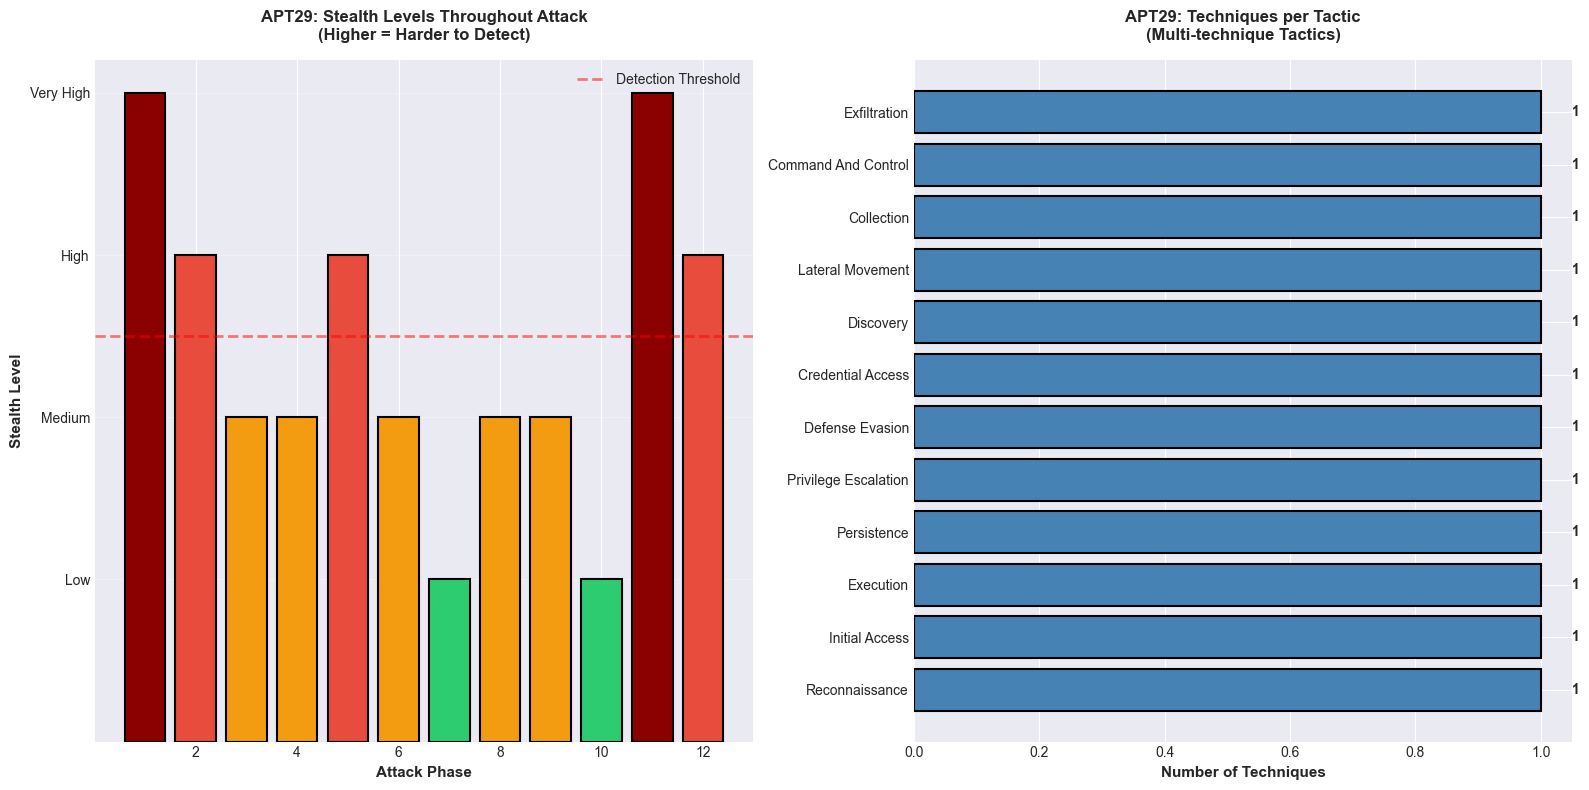


🔍 APT29 Characteristics:
  • LONG dwell time (months to years)
  • HEAVY use of living-off-the-land techniques
  • ADVANCED anti-forensics and evasion
  • REQUIRES layered detection: behavioral analytics, threat hunting, UEBA


In [ ]:
# ============================================================================
# VISUALIZE APT29 ATTACK COMPLEXITY
# ============================================================================
# Purpose: Show how stealth varies across phases and which tactics are emphasized
#
# Two visualizations:
# 1. Stealth levels throughout the attack (to identify hard-to-detect phases)
# 2. Technique distribution across tactics (to see attack focus areas)

print("📊 Creating APT29 attack complexity visualizations...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# -----------------------------------------------------------------------
# Chart 1: Stealth Levels Across Attack Phases
# -----------------------------------------------------------------------
# Purpose: Show which phases are hardest to detect
# Higher bars = Harder to detect = More sophisticated evasion

# Convert stealth ratings to numeric scores for visualization
stealth_map = {'Very High': 4, 'High': 3, 'Medium': 2, 'Low': 1}
apt29_df['Stealth_Score'] = apt29_df['Stealth'].map(stealth_map)

# Color bars based on stealth level (darker = more stealthy)
colors_stealth = apt29_df['Stealth_Score'].map({
    4: '#8b0000',    # Dark red - Very High stealth (hardest to detect)
    3: '#e74c3c',    # Red - High stealth
    2: '#f39c12',    # Orange - Medium stealth
    1: '#2ecc71'     # Green - Low stealth (easier to detect)
})

ax1.bar(apt29_df['Phase'], apt29_df['Stealth_Score'], color=colors_stealth, 
        edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Attack Phase', fontsize=11, fontweight='bold')
ax1.set_ylabel('Stealth Level', fontsize=11, fontweight='bold')
ax1.set_title('APT29: Stealth Levels Throughout Attack\n' + 
              '(Higher = Harder to Detect)', 
              fontsize=12, fontweight='bold', pad=15)
ax1.set_yticks(range(1, 5))
ax1.set_yticklabels(['Low', 'Medium', 'High', 'Very High'])

# Add reference line showing detection threshold
# Phases above this line require advanced detection capabilities
ax1.axhline(y=2.5, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='Advanced Detection Required')
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# -----------------------------------------------------------------------
# Chart 2: Techniques per Tactic
# -----------------------------------------------------------------------
# Purpose: Show which tactics APT29 emphasizes
# Multiple techniques in one tactic = thorough coverage of that attack stage

tactic_counts = apt29_df['Tactic'].value_counts()
tactic_labels = [t.replace('-', ' ').title() for t in tactic_counts.index]

ax2.barh(tactic_labels, tactic_counts.values, color='steelblue', 
         edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Number of Techniques Used', fontsize=11, fontweight='bold')
ax2.set_title('APT29: Techniques per Tactic\n' + 
              '(Shows Attack Focus Areas)', 
              fontsize=12, fontweight='bold', pad=15)

# Add value labels on bars
for i, v in enumerate(tactic_counts.values):
    ax2.text(v + 0.05, i, str(v), va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# Analysis and Insights
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🔍 APT29 ATTACK CHARACTERISTICS & DETECTION CHALLENGES")
print("="*80)

print("\n1. 📊 STEALTH ANALYSIS (Chart 1):")
very_high_stealth = apt29_df[apt29_df['Stealth'] == 'Very High']
print(f"   • Phases with VERY HIGH stealth: {len(very_high_stealth)}")
print(f"     These phases include:")
for _, phase in very_high_stealth.iterrows():
    print(f"     - Phase {phase['Phase']}: {phase['Name']}")

print(f"\n   • Average stealth score: {apt29_df['Stealth_Score'].mean():.2f}/4")
print(f"   • {len(apt29_df[apt29_df['Stealth_Score'] >= 3])} phases require advanced detection")

print("\n2. 🎯 TACTICAL FOCUS (Chart 2):")
print(f"   • APT29 uses techniques across {len(tactic_counts)} different tactics")
print(f"   • Most emphasized tactics:")
for tactic, count in tactic_counts.head(3).items():
    print(f"     - {tactic.replace('-', ' ').title()}: {count} technique(s)")

print("\n3. ⏱️ DWELL TIME:")
print("   • APT29 campaigns often last MONTHS to YEARS")
print("   • Compare to WannaCry: Hours to days")
print("   • Reason: Stealth > Speed for espionage operations")
print("   • Implication: Traditional \"fast\" detection methods won't work")

print("\n4. 🛠️ LIVING OFF THE LAND (LoL):")
print("   • Heavy use of legitimate tools:")
print("     - PowerShell (Phase 3)")
print("     - Registry (Phase 4)")
print("     - Windows Admin Shares (Phase 9)")
print("     - Built-in archiving tools (Phase 10)")
print("   • Why? Legitimate tools don't trigger malware signatures")
print("   • Detection approach: Behavioral, not signature-based")

print("\n5. 🔐 ADVANCED DETECTION REQUIREMENTS:")
print("   ✅ What's needed to detect APT29:")
print("      • Behavioral analytics (detect anomalies in normal tool usage)")
print("      • User and Entity Behavior Analytics (UEBA)")
print("      • Threat hunting (proactive searching for TTPs)")
print("      • Advanced logging:")
print("        - PowerShell script block logging")
print("        - Sysmon for detailed process/network monitoring")
print("        - EDR for endpoint visibility")
print("      • Deception technology (honeypots to detect reconnaissance)")
print("      • Long-term log retention (to analyze historical patterns)")

print("\n6. ⚠️ WHY APT29 IS HARD TO CATCH:")
print("   • Uses tools that admins use every day (hard to distinguish)")
print("   • Slow, patient operations (no sudden spikes to trigger alerts)")
print("   • Encrypted C2 over HTTPS (blends with normal traffic)")
print("   • Anti-forensics techniques (clears logs, removes traces)")
print("   • Custom/zero-day exploits (no signatures)")
print("   • Human operators adapting in real-time (not automated)")

print("\n" + "="*80)
print("💡 KEY TAKEAWAY:")
print("   APT29 demonstrates why signature-based detection is insufficient.")
print("   Modern threats require: Behavioral analytics + Threat hunting + UEBA")
print("   Detection is not a product you buy - it's a program you build.")
print("="*80)

---

## Part 3: Building Detection Rules

**Objective:** Translate ATT&CK techniques into actionable detection logic.

### 🎓 What Are Detection Rules?

**Detection rules** are queries/logic that run on your security data (logs, network traffic, endpoint telemetry) to identify suspicious activity.

**Think of them as:**
- Automated "watchdogs" constantly looking for specific patterns
- Translation of threat intelligence into technical searches
- The bridge between ATT&CK knowledge and actual detection

### 📝 Anatomy of a Good Detection Rule:

A production-ready detection rule needs:
1. **Technique Mapping:** Which ATT&CK technique does it detect?
2. **Data Source:** What logs/telemetry is required?
3. **Detection Logic:** The actual query/code
4. **False Positive Mitigation:** How to reduce noise
5. **Response Actions:** What to do when it triggers

### 🎯 Rules We'll Build:

We'll create detection rules for **high-priority techniques** identified in our case studies:
- T1003.001: LSASS Memory Dumping (credential theft)
- T1059.001: PowerShell Obfuscation (malicious scripting)
- T1486: Data Encrypted for Impact (ransomware)
- T1210: SMB Lateral Movement (worm behavior)
- T1071.001: C2 Beaconing (command & control)

**Note:** The queries use pseudo-SIEM syntax (similar to KQL/Splunk). You'll need to adapt them to your specific SIEM platform (Sentinel, Splunk, ELK, etc.).

In [ ]:
# ============================================================================
# DETECTION RULE FRAMEWORK
# ============================================================================
# Purpose: Create production-ready detection rules for high-priority techniques
#
# What makes a good detection rule?
# 1. Targets a specific ATT&CK technique
# 2. Has clear data source requirements
# 3. Includes working detection logic (query)
# 4. Addresses false positives
# 5. Defines response actions
#
# These rules use pseudo-SIEM syntax (KQL-like) - adapt to your platform

detection_rules = [
    {
        'Rule_ID': 'DR-001',
        'Technique': 'T1003.001',
        'Technique_Name': 'LSASS Memory Dumping',
        'Severity': 'Critical',
        'Data_Source': 'Process Monitoring (Sysmon Event ID 10)',
        'Detection_Logic': '''
// PURPOSE: Detect credential dumping via LSASS memory access
// WHY: Attackers dump LSASS to steal passwords/hashes (Mimikatz, ProcDump)
// WHEN: This runs continuously on Sysmon Event ID 10 (ProcessAccess)

ProcessAccess
| where TargetImage endswith "lsass.exe"          // Targeting LSASS process
| where GrantedAccess in ("0x1010", "0x1410", "0x147a")  // Suspicious access rights
| where SourceImage !in (                         // Exclude legitimate processes
    "wininit.exe", 
    "svchost.exe", 
    "wmiprvse.exe",
    "MsMpEng.exe"  // Windows Defender
  )
| project TimeGenerated, Computer, SourceImage, SourceProcessId, 
          TargetImage, GrantedAccess, User
| extend Severity = "Critical"
        ''',
        'False_Positive_Mitigation': '''
• Whitelist legitimate security tools (EDR agents, AV software)
• Validate source process has valid digital signature
• Check parent process (should be Windows system process)
• Correlate with other suspicious activity
        ''',
        'Response_Action': '''
IMMEDIATE ACTIONS (within 5 minutes):
1. Isolate affected host from network
2. Collect memory dump for forensics
3. Rotate credentials for accounts used on that system
4. Check for lateral movement to other systems

INVESTIGATION:
5. Review parent process and command line
6. Check for Mimikatz indicators (file names, registry keys)
7. Analyze network connections for C2
        ''',
        'Required_Logging': 'Sysmon with ProcessAccess logging enabled'
    },
    {
        'Rule_ID': 'DR-002',
        'Technique': 'T1059.001',
        'Technique_Name': 'PowerShell Obfuscation',
        'Severity': 'High',
        'Data_Source': 'PowerShell Script Block Logging (Event ID 4104)',
        'Detection_Logic': '''
// PURPOSE: Detect obfuscated/malicious PowerShell
// WHY: Attackers use obfuscation to evade detection (APT29, many others)
// WHEN: Runs on PowerShell Event ID 4104 (Script Block Logging)

Event
| where EventID == 4104  // Script Block Logging
| where ScriptBlockText matches regex @"(?i)(invoke-expression|iex|invoke-command|icm)"
     // Common execution commands
| where ScriptBlockText matches regex @"[\-\^]{5,}"  
     // Heavy use of obfuscation characters
| where ScriptBlockText matches regex @"(frombase64|convert.*base64)"
     // Base64 encoding (common in malicious scripts)
| where ScriptBlockText !contains "# Approved Script"  
     // Exclude approved scripts
| project TimeGenerated, Computer, ScriptBlockText, UserName, 
          ScriptBlockId, Path
| extend Severity = "High"
        ''',
        'False_Positive_Mitigation': '''
• Exclude known administrative scripts (with digital signatures)
• Whitelist scripts from approved directories (e.g., C:\\AdminTools)
• Check if script is signed by trusted publisher
• Review script context (was it run by admin or regular user?)
        ''',
        'Response_Action': '''
IMMEDIATE:
1. Capture full script content for analysis
2. Check for network connections (C2 communication)
3. EDR investigation on endpoint

ANALYSIS:
4. Deobfuscate script to understand intent
5. Check for file/registry modifications
6. Look for similar scripts on other systems
        ''',
        'Required_Logging': 'PowerShell Script Block Logging enabled via Group Policy'
    },
    {
        'Rule_ID': 'DR-003',
        'Technique': 'T1486',
        'Technique_Name': 'Data Encrypted for Impact (Ransomware)',
        'Severity': 'Critical',
        'Data_Source': 'File System Monitoring',
        'Detection_Logic': '''
// PURPOSE: Detect ransomware encryption activity
// WHY: Catch ransomware DURING encryption (not after ransom note)
// WHEN: Continuous monitoring of file modification events

FileEvents
| where ActionType == "FileModified"
| summarize FileChanges = count(),                // Count modifications
            DistinctExtensions = dcount(FileExtension),  // Unique extensions
            Extensions = make_set(FileExtension)  // List of extensions
  by bin(TimeGenerated, 1m), DeviceName, ProcessName, User
  
| where FileChanges > 50  // High volume of file changes (configurable)
| where DistinctExtensions < 5  // Limited file types (mass encryption)
| where Extensions has_any (".encrypted", ".locked", ".crypto", ".wcry")
     // Known ransomware extensions
     
| extend Severity = "Critical"
| project TimeGenerated, DeviceName, ProcessName, User, 
          FileChanges, Extensions
        ''',
        'False_Positive_Mitigation': '''
• Baseline normal file activity per user/system
• Exclude backup processes and file sync tools (OneDrive, Dropbox)
• Whitelist known bulk operations (batch processing, ETL jobs)
• Adjust FileChanges threshold based on environment
        ''',
        'Response_Action': '''
‼️ IMMEDIATE (within 1 minute):
1. ISOLATE affected system from network (prevent spread)
2. Network segmentation if possible
3. Snapshot/backup any remaining unencrypted files

CONTAINMENT:
4. Check for lateral movement (SMB, RDP connections)
5. Disable compromised accounts
6. Restore from offline backups

DO NOT PAY RANSOM - No guarantee of decryption
        ''',
        'Required_Logging': 'File system auditing on critical servers/shares'
    },
    {
        'Rule_ID': 'DR-004',
        'Technique': 'T1210',
        'Technique_Name': 'SMB Lateral Movement',
        'Severity': 'High',
        'Data_Source': 'Network Traffic Monitoring',
        'Detection_Logic': '''
// PURPOSE: Detect worm-like lateral movement via SMB
// WHY: Catches WannaCry-style propagation and APT lateral movement
// WHEN: Real-time network traffic analysis

NetworkEvents
| where RemotePort == 445  // SMB port
| summarize DestinationCount = dcount(RemoteIP),  // Count unique destinations
            Destinations = make_set(RemoteIP)
  by bin(TimeGenerated, 5m), SourceIP, ProcessName, User
  
| where DestinationCount > 10  // Connecting to many hosts rapidly
| where ProcessName !in ("System", "svchost.exe")  // Not Windows networking
| where User !in (approved_admin_accounts)  // Not known admin
| extend Severity = "High"
        ''',
        'False_Positive_Mitigation': '''
• Exclude known admin workstations (IT management systems)
• Whitelist IT management tools (SCCM, vulnerability scanners)
• Check if user is in privileged access management (PAM) system
• Validate time of day (admins don't work at 3 AM)
        ''',
        'Response_Action': '''
IMMEDIATE:
1. Investigate SOURCE system (likely compromised)
2. Check for stolen credentials (admin account usage)
3. Disable compromised account

ANALYSIS:
4. Review what was accessed on destination systems
5. Check for malware deployment (new services, files)
6. Forensics on source system
        ''',
        'Required_Logging': 'Network flow logs or NDR (Network Detection & Response)'
    },
    {
        'Rule_ID': 'DR-005',
        'Technique': 'T1071.001',
        'Technique_Name': 'C2 Beaconing Detection',
        'Severity': 'High',
        'Data_Source': 'Network Traffic (Proxy, Firewall)',
        'Detection_Logic': '''
// PURPOSE: Detect periodic C2 beacon traffic
// WHY: C2 malware "phones home" on regular intervals (beaconing)
// WHEN: Statistical analysis of network connections

NetworkEvents  
| where RemotePort in (80, 443, 8080)  // Common C2 ports
| summarize Connections = count(),     // How many connections
            AvgInterval = avg(prev(TimeGenerated) - TimeGenerated),  // Time between
            StdDevInterval = stdev(prev(TimeGenerated) - TimeGenerated)
  by bin(TimeGenerated, 1h), SourceIP, RemoteIP, ProcessName
  
| where Connections between (10 .. 100)  // Not too few, not too many
| where AvgInterval between (50s .. 70s)  // Regular interval (60s ± 10s)
| where StdDevInterval < 5s  // Very consistent timing
| where RemoteIP !in (trusted_cloud_services)  // Not known-good
| extend Severity = "High"
        ''',
        'False_Positive_Mitigation': '''
• Whitelist known update servers (Windows Update, antivirus updates)
• Exclude monitoring agents with regular check-ins
• Whitelist approved cloud services (Office 365, G Suite)
• Check destination reputation (threat intel feeds)
        ''',
        'Response_Action': '''
IMMEDIATE:
1. Block C2 domain/IP at firewall
2. Isolate affected host
3. Capture network traffic (PCAP) for analysis

FORENSICS:
4. Identify C2 malware on endpoint
5. Determine initial access method
6. Check for data exfiltration
7. Hunt for similar beaconing patterns
        ''',
        'Required_Logging': 'Network proxy logs with timestamps, or PCAP analysis'
    }
]

# Convert to DataFrame
rules_df = pd.DataFrame(detection_rules)

# -----------------------------------------------------------------------
# Display Detection Rules
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🛡️ DETECTION RULE LIBRARY")
print("="*80)
print("\nProduction-ready detection rules for high-priority ATT&CK techniques\n")

for idx, rule in rules_df.iterrows():
    print(f"\n{'█'*80}")
    print(f"  {rule['Rule_ID']}: {rule['Technique_Name']} ({rule['Technique']})")
    print(f"{'█'*80}")
    print(f"\n📊 Severity: {rule['Severity']}")
    print(f"📁 Data Source: {rule['Data_Source']}")
    print(f"⚙️  Required: {rule['Required_Logging']}")
    
    print(f"\n📝 DETECTION LOGIC:")
    print(rule['Detection_Logic'])
    
    print(f"\n⚠️  FALSE POSITIVE MITIGATION:")
    print(rule['False_Positive_Mitigation'])
    
    print(f"\n🚨 RESPONSE ACTIONS:")
    print(rule['Response_Action'])

print("\n" + "="*80)
print("💡 HOW TO USE THESE RULES:")
print("="*80)
print("\n1. ADAPT THE SYNTAX:")
print("   • These use pseudo-KQL (Azure Sentinel style)")
print("   • Convert to your SIEM's query language:")
print("     - Splunk: SPL")
print("     - Elasticsearch: EQL or Lucene")
print("     - Sentinel: KQL (minimal changes)")
print("     - Chronicle: YARA-L")

print("\n2. TUNE THRESHOLDS:")
print("   • FileChanges > 50 might be too low/high for your environment")
print("   • Adjust based on baseline normal activity")
print("   • Use gradual rollout: Monitor first, then alert")

print("\n3. TEST BEFORE DEPLOYMENT:")
print("   • Run in 'detect-only' mode initially")
print("   • Collect false positives for 1-2 weeks")
print("   • Refine whitelist/threshold")
print("   • Then enable automated response")

print("\n4. MAINTAIN WHITELISTS:")
print("   • Keep approved_admin_accounts up to date")
print("   • Review trusted_cloud_services regularly")
print("   • Document all whitelisted items")

print("\n5. MEASURE EFFECTIVENESS:")
print("   • Track true positives vs. false positives")
print("   • Mean time to detect (MTTD)")
print("   • Mean time to respond (MTTR)")
print("   • Regularly test with purple team exercises")

print("\n" + "="*80)


🛡️ Detection Rules for High-Priority Techniques:


DR-001: LSASS Memory Dumping (T1003.001)
Severity: Critical | Data Source: Process Monitoring

Detection Logic:
// Detect processes accessing LSASS memory
ProcessAccess
| where TargetImage contains "lsass.exe"
| where GrantedAccess in ("0x1010", "0x1410", "0x147a")
| where SourceImage !in ("wininit.exe", "svchost.exe", "wmiprvse.exe")
| project TimeGenerated, SourceImage, SourceProcessId, TargetImage, GrantedAccess
        

False Positive Mitigation: Whitelist legitimate security tools, validate with parent process
Response: Isolate host, collect memory dump, credential rotation

DR-002: PowerShell Obfuscation (T1059.001)
Severity: High | Data Source: PowerShell Script Block Logging

Detection Logic:
// Detect obfuscated PowerShell
Event
| where EventID == 4104  // Script Block Logging
| where ScriptBlockText matches regex @"(?i)(invoke-expression|iex|invoke-command|icm)"
| where ScriptBlockText matches regex @"[\-\^]{5,}"
| where Sc

---

## Part 4: Organizational Coverage Heatmap

**Objective:** Assess which ATT&CK techniques your organization can actually detect.

### 🎯 Why Coverage Analysis Matters:

**The Problem:**
- ATT&CK has 200+ techniques across 14 tactics
- No organization can detect everything
- Resources are limited (tools, people, budget)

**The Solution:**
- **Coverage mapping** shows what you CAN detect vs. what you CAN'T
- Helps prioritize security investments
- Identifies dangerous blind spots
- Tracks improvement over time

### 📊 What is a Coverage Heatmap?

A **coverage heatmap** visualizes your detection capabilities across the ATT&CK matrix:
- **Green:** Good coverage (can detect most techniques in this tactic)
- **Yellow:** Moderate coverage (some gaps)
- **Red:** Poor coverage (many blind spots)

### 🔍 How to Build One:

**Step 1:** Inventory your security tools
- SIEM (e.g., Splunk, Sentinel, ELK)
- EDR (e.g., CrowdStrike, Carbon Black, Defender)
- Network monitoring (e.g., IDS/IPS, NDR)
- Cloud security (e.g., CASB, CWPP)

**Step 2:** Map tools to ATT&CK data sources
- Each tool provides visibility into certain data sources
- Each technique requires certain data sources for detection

**Step 3:** Calculate coverage per tactic
- For each tactic, count: Total techniques vs. Detectable techniques
- Formula: Coverage % = (Detectable / Total) × 100

**Note:** In this example, we'll **simulate** coverage data. In a real scenario, you'd map your actual tool inventory.

In [ ]:
# ============================================================================
# ORGANIZATIONAL COVERAGE MATRIX
# ============================================================================
# Purpose: Create ATT&CK coverage heatmap for your organization
#
# In this simulation:
# - We'll generate realistic coverage percentages per tactic
# - In production, you'd map your actual security tools to techniques
#
# How to do this for real:
# 1. List all security tools (SIEM, EDR, IDS, etc.)
# 2. Map each tool to ATT&CK data sources
# 3. For each technique, check if you have required data sources
# 4. Calculate coverage = (detectable techniques) / (total techniques)

def create_coverage_matrix(attack_store):
    """
    Build organizational ATT&CK coverage matrix
    
    Parameters:
        attack_store: ATT&CK data store
    
    Returns:
        DataFrame with coverage statistics per tactic
    
    Note: This simulates realistic coverage. Replace with your actual
          tool inventory mapping for production use.
    """
    print("🔨 Building organizational ATT&CK coverage matrix...")
    print("   (Simulated data - replace with your tool inventory)\n")
    
    # -----------------------------------------------------------------------
    # Get all tactics in Kill Chain order
    # -----------------------------------------------------------------------
    tactic_order = [
        'reconnaissance',        # 🔍 Gathering information
        'resource-development',  # 🛠️ Setting up infrastructure
        'initial-access',        # 🚪 Getting in
        'execution',             # ⚡ Running code
        'persistence',           # 🔒 Maintaining access
        'privilege-escalation',  # 👑 Getting admin rights
        'defense-evasion',       # 🥷 Avoiding detection
        'credential-access',     # 🔑 Stealing credentials
        'discovery',             # 🗺️ Learning the environment
        'lateral-movement',      # ↔️ Moving between systems
        'collection',            # 📦 Gathering data
        'command-and-control',   # 📡 Communication with attacker
        'exfiltration',          # 📤 Stealing data
        'impact'                 # 💥 Destruction/disruption
    ]
    
    # -----------------------------------------------------------------------
    # Get all techniques from ATT&CK
    # -----------------------------------------------------------------------
    techniques = attack_store.query([Filter("type", "=", "attack-pattern")])
    
    # -----------------------------------------------------------------------
    # Build coverage data for each tactic
    # -----------------------------------------------------------------------
    coverage_data = []
    
    for tactic_name in tactic_order:
        # Find techniques for this tactic
        tactic_techniques = []
        for tech in techniques:
            # Skip revoked/deprecated techniques
            if tech.get('revoked') or tech.get('x_mitre_deprecated'):
                continue
            
            tech_id = tech['external_references'][0]['external_id']
            
            # Skip sub-techniques (we're analyzing at parent level)
            if '.' in tech_id:
                continue
            
            # Check if technique belongs to this tactic
            kill_chain = tech.get('kill_chain_phases', [])
            if any(phase['phase_name'] == tactic_name for phase in kill_chain):
                tactic_techniques.append(tech_id)
        
        # -----------------------------------------------------------------------
        # SIMULATE COVERAGE (Replace this with real tool mapping!)
        # -----------------------------------------------------------------------
        # In production, you'd:
        # 1. Check which data sources you have (e.g., process logs, network traffic)
        # 2. For each technique, check if you have required data sources
        # 3. Count detectable vs. total techniques
        
        import random
        random.seed(42)  # Reproducible results
        
        # Realistic coverage rates based on typical org capabilities
        # These reflect that some tactics are naturally easier to detect
        coverage_rates = {
            'reconnaissance': 0.2,         # Hard - happens outside your network
            'resource-development': 0.1,   # Very hard - happens before attack
            'initial-access': 0.6,         # Good - email gateways, perimeter
            'execution': 0.7,              # Good - EDR, process monitoring
            'persistence': 0.5,            # Moderate - registry, services
            'privilege-escalation': 0.4,   # Harder - memory operations
            'defense-evasion': 0.3,        # Hard - designed to avoid detection
            'credential-access': 0.6,      # Good - LSASS monitoring
            'discovery': 0.4,              # Moderate - blends with normal
            'lateral-movement': 0.5,       # Moderate - network monitoring
            'collection': 0.5,             # Moderate - file access auditing
            'command-and-control': 0.6,    # Good - network/proxy logs
            'exfiltration': 0.5,           # Moderate - DLP, network
            'impact': 0.7                  # Good - file changes, high I/O
        }
        
        total = len(tactic_techniques)
        covered = int(total * coverage_rates.get(tactic_name, 0.4))
        gap = total - covered
        
        coverage_data.append({
            'Tactic': tactic_name.replace('-', ' ').title(),
            'Total_Techniques': total,
            'Covered_Techniques': covered,
            'Coverage_Percentage': (covered / total * 100) if total > 0 else 0,
            'Gap': gap,
            'Gap_Percentage': (gap / total * 100) if total > 0 else 0
        })
    
    print("✓ Coverage matrix created\n")
    return pd.DataFrame(coverage_data)


# ============================================================================
# CREATE AND DISPLAY COVERAGE MATRIX
# ============================================================================
print("="*80)
print("📊 ORGANIZATIONAL ATT&CK COVERAGE ANALYSIS")
print("="*80 + "\n")

coverage_df = create_coverage_matrix(attack)

# Display the full table
print("Coverage by Tactic:\n")
print(coverage_df[['Tactic', 'Total_Techniques', 'Covered_Techniques', 
                   'Coverage_Percentage', 'Gap']].to_string(index=False))

# -----------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("📈 SUMMARY STATISTICS")
print("="*80)

total_techniques = coverage_df['Total_Techniques'].sum()
total_covered = coverage_df['Covered_Techniques'].sum()
overall_coverage = (total_covered / total_techniques * 100)

print(f"\n🔢 Overall Coverage:")
print(f"   • Total techniques in Enterprise ATT&CK: {total_techniques}")
print(f"   • Techniques with detection capability: {total_covered}")
print(f"   • Overall coverage: {overall_coverage:.1f}%")
print(f"   • Total gap (blind spots): {total_techniques - total_covered} techniques")

print(f"\n🏆 Best Covered Tactics (Top 3):")
best_3 = coverage_df.nlargest(3, 'Coverage_Percentage')
for _, row in best_3.iterrows():
    print(f"   • {row['Tactic']}: {row['Coverage_Percentage']:.1f}% coverage")

print(f"\n⚠️  Worst Covered Tactics (Bottom 3):")
worst_3 = coverage_df.nsmallest(3, 'Coverage_Percentage')
for _, row in worst_3.iterrows():
    print(f"   • {row['Tactic']}: {row['Coverage_Percentage']:.1f}% coverage ({row['Gap']} techniques uncovered)")

print(f"\n🎯 Industry Benchmark:")
print(f"   • Your coverage: {overall_coverage:.1f}%")
print(f"   • Mature organizations: 50-60%")
print(f"   • Advanced organizations: 60-70%")
print(f"   • Note: 100% coverage is unrealistic and unnecessary")

print("="*80)

Building organizational coverage matrix...


📊 Organizational ATT&CK Coverage:

              Tactic  Total_Techniques  Covered_Techniques  Coverage_Percentage  Gap
      Reconnaissance                11                   2            18.181818    9
Resource Development                 8                   0             0.000000    8
      Initial Access                11                   6            54.545455    5
           Execution                17                  11            64.705882    6
         Persistence                23                  11            47.826087   12
Privilege Escalation                14                   5            35.714286    9
     Defense Evasion                47                  14            29.787234   33
   Credential Access                17                  10            58.823529    7
           Discovery                34                  13            38.235294   21
    Lateral Movement                 9                   4            

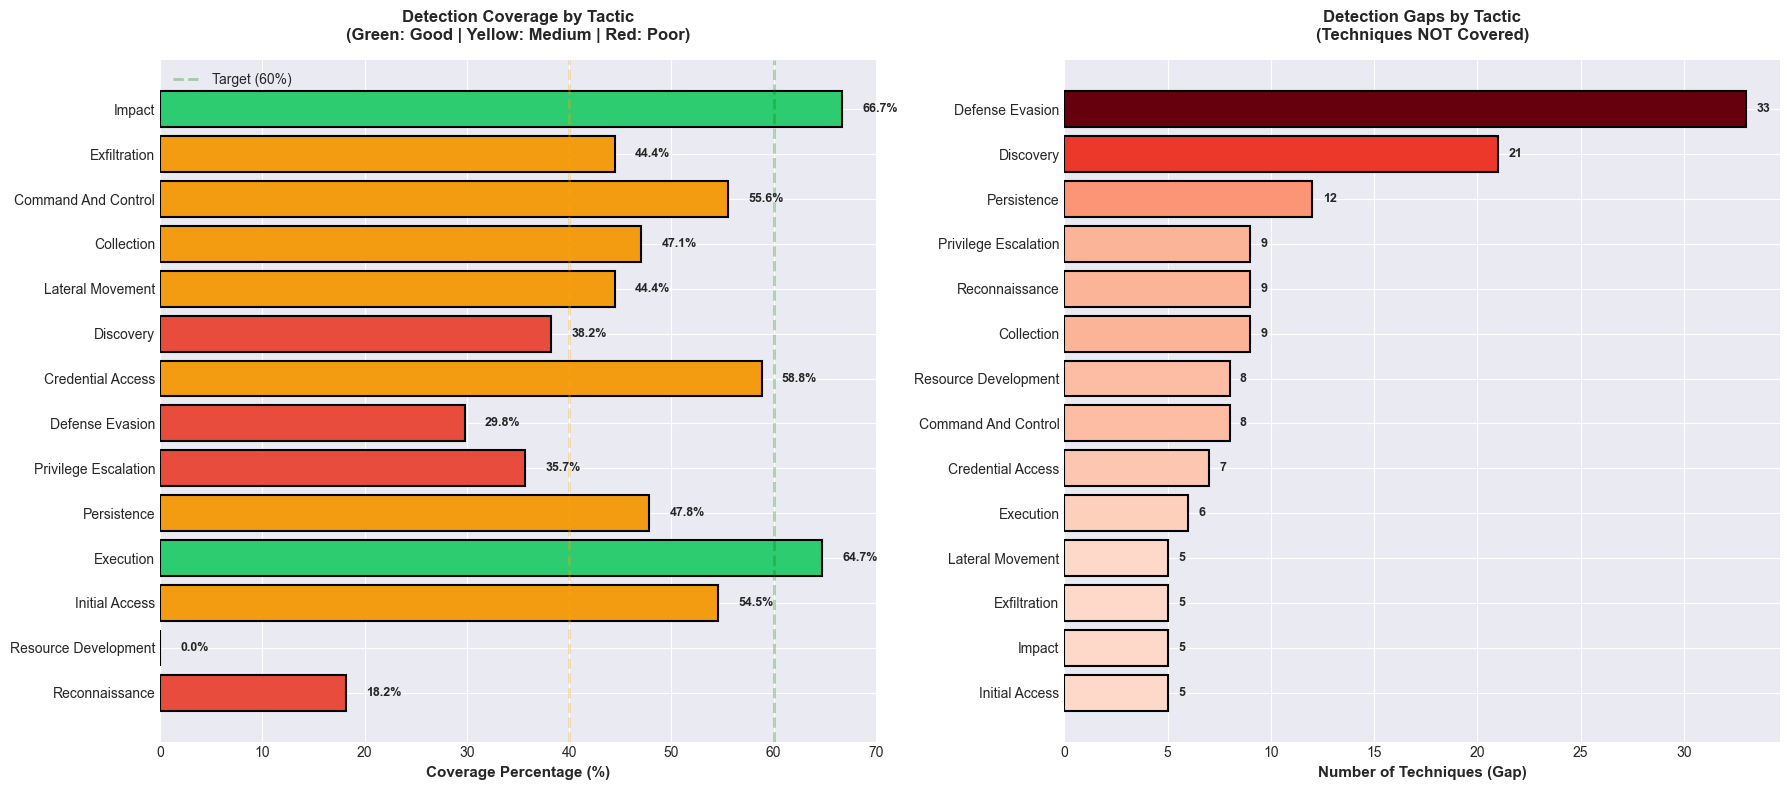


🎯 Priority Recommendations:

Tactics with WORST coverage (prioritize improvements):
  • Resource Development: 0.0% coverage (8 techniques uncovered)
  • Reconnaissance: 18.2% coverage (9 techniques uncovered)
  • Defense Evasion: 29.8% coverage (33 techniques uncovered)

Recommended Actions:
  1. Instrument data sources for uncovered techniques
  2. Deploy detection rules from earlier in this notebook
  3. Focus on popular techniques (from Notebook 2 analysis)
  4. Run purple team exercises to validate detection


In [ ]:
# ============================================================================
# VISUALIZE COVERAGE GAPS
# ============================================================================
# Purpose: Create visual representations to communicate coverage to stakeholders
#
# Two charts:
# 1. Coverage percentage by tactic (shows where you're strong/weak)
# 2. Gap analysis (shows number of uncovered techniques per tactic)

print("\n📊 Creating coverage visualizations...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# -----------------------------------------------------------------------
# Chart 1: Coverage Percentage by Tactic
# -----------------------------------------------------------------------
# Purpose: Quick visual of detection maturity per tactic
# Color coding: Green (good) > Yellow (okay) > Red (poor)

# Color bars based on coverage level
colors = coverage_df['Coverage_Percentage'].map(
    lambda x: '#2ecc71' if x >= 60 else ('#f39c12' if x >= 40 else '#e74c3c')
)

bars1 = ax1.barh(coverage_df['Tactic'], coverage_df['Coverage_Percentage'], 
                 color=colors, edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Coverage Percentage (%)', fontsize=11, fontweight='bold')
ax1.set_title('Detection Coverage by Tactic\n' +
              'Green: Good (≥60%) | Yellow: Medium (40-59%) | Red: Poor (<40%)', 
              fontsize=12, fontweight='bold', pad=15)

# Add reference lines
ax1.axvline(x=60, color='green', linestyle='--', linewidth=2, alpha=0.3, 
           label='Target: 60% (Good)')
ax1.axvline(x=40, color='orange', linestyle='--', linewidth=2, alpha=0.3,
           label='Minimum: 40% (Acceptable)')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels on bars
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 2, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center', fontweight='bold', fontsize=9)

# -----------------------------------------------------------------------
# Chart 2: Gap Analysis (Uncovered Techniques)
# -----------------------------------------------------------------------
# Purpose: Show absolute number of blind spots per tactic
# Helps prioritize where to invest in detection capabilities

coverage_df_sorted = coverage_df.sort_values('Gap', ascending=True)

# Color gradient: darker red = more gaps
colors2 = plt.cm.Reds([gap/coverage_df['Gap'].max() if coverage_df['Gap'].max() > 0 else 0 
                       for gap in coverage_df_sorted['Gap']])

bars2 = ax2.barh(coverage_df_sorted['Tactic'], coverage_df_sorted['Gap'], 
                 color=colors2, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Number of Uncovered Techniques', fontsize=11, fontweight='bold')
ax2.set_title('Detection Gaps by Tactic\n' +
              '(Number of Techniques WITHOUT Detection Coverage)', 
              fontsize=12, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)

# Add gap count labels
for bar in bars2:
    width = bar.get_width()
    if width > 0:
        ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# Priority Recommendations
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 PRIORITY RECOMMENDATIONS")
print("="*80)

print("\n1. TACTICS WITH WORST COVERAGE (Immediate Focus):")
worst_coverage = coverage_df.nsmallest(3, 'Coverage_Percentage')
for idx, row in worst_coverage.iterrows():
    print(f"\n   🔴 {row['Tactic']}:")
    print(f"      • Current coverage: {row['Coverage_Percentage']:.1f}%")
    print(f"      • Uncovered techniques: {row['Gap']}")
    print(f"      • Impact: {'CRITICAL - Early kill chain' if idx < 3 else 'HIGH - Mid/Late chain'}")
    
    # Provide specific recommendations per tactic
    if 'Reconnaissance' in row['Tactic']:
        print(f"      • Recommendation: Deploy deception technology (honeytokens)")
    elif 'Initial Access' in row['Tactic']:
        print(f"      • Recommendation: Enhance email security, phishing simulations")
    elif 'Defense Evasion' in row['Tactic']:
        print(f"      • Recommendation: Implement behavioral analytics, EDR")

print("\n\n2. RECOMMENDED ACTIONS (Prioritized):")
print("   ┌─ QUICK WINS (30-60 days):")
print("   │  ├─ Enable PowerShell script block logging (Group Policy)")
print("   │  ├─ Deploy Sysmon on critical servers")
print("   │  ├─ Implement detection rules from Part 3 of this notebook")
print("   │  └─ Set up LSASS access monitoring")
print("   │")
print("   ├─ SHORT TERM (3-6 months):")
print("   │  ├─ Deploy EDR on all endpoints")
print("   │  ├─ Enhance SIEM correlation rules")
print("   │  ├─ Implement network traffic analysis (NTA)")
print("   │  └─ Establish threat hunting program")
print("   │")
print("   └─ LONG TERM (6-12 months):")
print("      ├─ Implement UEBA (User & Entity Behavior Analytics)")
print("      ├─ Deploy deception technology")
print("      ├─ Enhance data loss prevention (DLP)")
print("      └─ Establish continuous purple team testing")

print("\n\n3. INVESTMENT PRIORITIES (Based on ROI):")
print("   Focus investments on techniques that are:")
print("   ✓ POPULAR (used by many threat groups - see Notebook 2)")
print("   ✓ CRITICAL (early kill chain or high impact)")
print("   ✓ DETECTABLE (have available data sources)")
print("   ✓ RELEVANT (target your industry/assets)")

print("\n\n4. MEASUREMENT & TRACKING:")
print("   Create a quarterly review process:")
print("   • Re-run this coverage analysis every 3 months")
print("   • Track coverage improvement over time")
print("   • Measure: New techniques covered, gaps closed")
print("   • Report to leadership: % coverage improvement")

print("\n\n5. ACCEPTANCE OF RISK:")
print("   You CANNOT detect everything - prioritize:")
print("   • Some tactics (Reconnaissance, Resource Development) are naturally hard")
print("   • Focus on tactics with high ROI (Initial Access, Execution, Impact)")
print("   • Accepted risk: Document tactics where coverage is intentionally low")
print("   • Compensating controls: Use prevention where detection is hard")

print("\n" + "="*80)
print("💡 REMEMBER:")
print("   Coverage is a JOURNEY, not a destination.")
print("   40-50% coverage of the right techniques > 80% coverage of irrelevant ones")
print("   Quality of detection > Quantity of alerts")
print("="*80)

---

## Part 5: Purple Team Exercise Design

**Objective:** Design a realistic purple team scenario to TEST whether your detections actually work.

### 🟣 What is Purple Teaming?

**Purple Team** = Red Team (attackers) + Blue Team (defenders) working together

**Traditional approach problems:**
- ❌ Red team attacks, blue team defends, minimal communication
- ❌ Red team wins → Blue team feels defeated
- ❌ Limited learning, competitive mindset

**Purple team approach:**
- ✅ Collaborative: Red shows blue what they did
- ✅ Educational: Both teams learn
- ✅ Validation: Tests if detections actually work
- ✅ Improvement: Identifies gaps, tunes rules

### 🎯 Why Purple Team Exercises?

**Detection rules are hypotheses** until proven. Purple teaming proves them:
- "We *think* we can detect LSASS dumping" → "We *confirmed* we detect it"
- Discovers blind spots before real attackers do
- Validates security investments work as intended
- Trains both SOC and incident response teams

### 📋 Components of a Good Purple Team Scenario:

1. **Clear Objectives:** What are we testing?
2. **Realistic TTPs:** Based on threat intelligence (like APT29)
3. **Defined Success Criteria:** What does "detected" mean?
4. **Safe Environment:** Isolated test network
5. **Measurement:** Did we detect? How fast?
6. **Improvement Plan:** What to fix based on results?

### 🎮 The Scenario We'll Design:

**APT29-Style Espionage Simulation**
- 7 phases covering the full attack chain
- Tests detection rules from Part 3
- Focuses on living-off-the-land techniques
- Duration: 4 hours (simulated, not real dwell time)

In [ ]:
# ============================================================================
# PURPLE TEAM EXERCISE PLAN
# ============================================================================
# Purpose: Create a comprehensive purple team scenario to validate detections
#
# Structure of each step:
# - Red Team Action: What the attacker does
# - Technique: ATT&CK technique ID
# - Execution: How to simulate it safely
# - Expected Artifact: What evidence should be created
# - Blue Team Objective: What to detect
# - Success Criteria: When is it "detected"?
# - Tools Required: What security tools are needed

purple_team_plan = [
    {
        'Step': 1,
        'Red_Team_Action': 'Spearphishing Email',
        'Technique': 'T1566.002',
        'Execution': 'Send simulated phishing email to test users (pre-approved)',
        'Expected_Artifact': 'Email logs showing delivery, user interaction (click tracking)',
        'Blue_Team_Objective': 'Detect phishing email via email gateway or user report',
        'Success_Criteria': 'Email blocked by gateway OR user reported within 15 minutes',
        'Tools_Required': 'Email gateway with logging, SIEM, User awareness platform',
        'Safety_Notes': 'Use fake credentials, no real damage, test users informed'
    },
    {
        'Step': 2,
        'Red_Team_Action': 'Execute PowerShell Script',
        'Technique': 'T1059.001',
        'Execution': 'Run obfuscated PowerShell on test endpoint (approved system)',
        'Expected_Artifact': 'PowerShell event logs (Event ID 4104 - Script Block, 4103 - Module)',
        'Blue_Team_Objective': 'Detect PowerShell execution via script block logging',
        'Success_Criteria': 'Alert generated within 5 minutes, analyst reviews script',
        'Tools_Required': 'PowerShell logging enabled, EDR, SIEM with correlation rules',
        'Safety_Notes': 'Benign script that mimics malicious patterns, no actual payload'
    },
    {
        'Step': 3,
        'Red_Team_Action': 'Establish Persistence',
        'Technique': 'T1547.001',
        'Execution': 'Add registry Run key on test system (HKCU\\Software\\Microsoft\\Windows\\CurrentVersion\\Run)',
        'Expected_Artifact': 'Registry modification event (Sysmon Event ID 13)',
        'Blue_Team_Objective': 'Detect registry persistence mechanism creation',
        'Success_Criteria': 'Alert on registry modification to Run keys within 5 minutes',
        'Tools_Required': 'EDR with registry monitoring, Sysmon, SIEM',
        'Safety_Notes': 'Add benign entry, remove after test'
    },
    {
        'Step': 4,
        'Red_Team_Action': 'Credential Dumping',
        'Technique': 'T1003.001',
        'Execution': 'Use Mimikatz or ProcDump to access LSASS (in isolated test environment only!)',
        'Expected_Artifact': 'LSASS process access (Sysmon Event ID 10), .dmp file creation',
        'Blue_Team_Objective': 'Detect LSASS memory access and credential dumping attempt',
        'Success_Criteria': 'CRITICAL alert within 1 minute, process blocked if EDR has prevention',
        'Tools_Required': 'EDR with LSASS protection, Credential Guard (may block), SIEM',
        'Safety_Notes': 'TEST ENVIRONMENT ONLY! This is a critical security event'
    },
    {
        'Step': 5,
        'Red_Team_Action': 'Lateral Movement',
        'Technique': 'T1021.002',
        'Execution': 'Use PsExec or built-in tools to connect to adjacent test system via SMB',
        'Expected_Artifact': 'SMB connections (port 445), remote service creation (Event ID 7045)',
        'Blue_Team_Objective': 'Detect lateral movement via SMB and service creation',
        'Success_Criteria': 'Alert on unusual SMB activity and remote service within 10 minutes',
        'Tools_Required': 'EDR, Network monitoring (NDR or firewall logs), SIEM',
        'Safety_Notes': 'Only move between designated test systems, use test accounts'
    },
    {
        'Step': 6,
        'Red_Team_Action': 'Data Collection',
        'Technique': 'T1560.001',
        'Execution': 'Archive test files using 7zip, WinRAR, or built-in compress utility',
        'Expected_Artifact': 'Archive file creation, high I/O, archiving tool process',
        'Blue_Team_Objective': 'Detect unusual archiving activity (mass file access)',
        'Success_Criteria': 'Alert on archiving tools + large file operations within 10 minutes',
        'Tools_Required': 'EDR with process monitoring, File activity monitoring, SIEM',
        'Safety_Notes': 'Use dummy test files, clearly labeled as test data'
    },
    {
        'Step': 7,
        'Red_Team_Action': 'Exfiltration Simulation',
        'Technique': 'T1041',
        'Execution': 'Upload test archive to external cloud storage via HTTPS (approved service)',
        'Expected_Artifact': 'Large outbound HTTPS transfer, connection to cloud service',
        'Blue_Team_Objective': 'Detect data exfiltration via network monitoring or DLP',
        'Success_Criteria': 'DLP alert OR network anomaly detection within 15 minutes',
        'Tools_Required': 'DLP solution, Web proxy with logging, CASB, Network monitoring',
        'Safety_Notes': 'Upload to approved test account, test data only, delete after'
    }
]

# Convert to DataFrame
purple_df = pd.DataFrame(purple_team_plan)

# -----------------------------------------------------------------------
# Display Purple Team Plan
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🟣 PURPLE TEAM EXERCISE: APT29-Style Espionage Simulation")
print("="*80)

print("\n📋 EXERCISE OVERVIEW:")
print("="*80)
print("Objective:    Validate detection capabilities against sophisticated threat actor TTPs")
print("Scenario:     APT29-style espionage campaign (compressed timeframe)")
print("Duration:     4 hours (execution + debrief)")
print("Environment:  Isolated test network with instrumented endpoints")
print("Participants: Red Team (2-3 people), Blue Team/SOC (analysts), Purple Lead")
print("="*80)

print("\n📝 DETAILED SCENARIO:\n")

for idx, step in purple_df.iterrows():
    print(f"\n{'▬'*80}")
    print(f"STEP {step['Step']}: {step['Red_Team_Action']} (ATT&CK: {step['Technique']})")
    print(f"{'▬'*80}")
    
    print(f"\n🔴 Red Team Actions:")
    print(f"   Execute: {step['Execution']}")
    print(f"   Produces: {step['Expected_Artifact']}")
    
    print(f"\n🔵 Blue Team Objectives:")
    print(f"   Goal: {step['Blue_Team_Objective']}")
    print(f"   Success if: {step['Success_Criteria']}")
    print(f"   Required tools: {step['Tools_Required']}")
    
    print(f"\n⚠️  Safety Considerations:")
    print(f"   {step['Safety_Notes']}")

# -----------------------------------------------------------------------
# Execution Timeline
# -----------------------------------------------------------------------
print("\n\n" + "="*80)
print("⏱️ EXECUTION TIMELINE (4 hours)")
print("="*80)

print("\n🕐 Hour 1: Preparation & Briefing (0:00 - 1:00)")
print("   • Purple lead briefs both teams")
print("   • Red team reviews tools and test environment")
print("   • Blue team ensures monitoring is active")
print("   • Validate communication channels (Slack, Teams, etc.)")

print("\n🕑 Hour 2: Execution Phase 1 (1:00 - 2:00)")
print("   • Steps 1-3: Initial Access → Persistence")
print("   • Red team executes at realistic pace (not all at once)")
print("   • Blue team monitors for alerts")
print("   • Purple lead coordinates timing")

print("\n🕒 Hour 3: Execution Phase 2 (2:00 - 3:00)")
print("   • Steps 4-7: Credential Access → Exfiltration")
print("   • Red team communicates what they're doing (AFTER each step)")
print("   • Blue team documents detections and response")
print("   • Note gaps in real-time")

print("\n🕓 Hour 4: Debrief & Improvement Planning (3:00 - 4:00)")
print("   • Review scorecard (see next cell)")
print("   • Discuss what worked, what didn't")
print("   • Document lessons learned")
print("   • Create improvement plan with owners and deadlines")

# -----------------------------------------------------------------------
# Pre-Exercise Checklist
# -----------------------------------------------------------------------
print("\n\n" + "="*80)
print("✅ PRE-EXERCISE CHECKLIST")
print("="*80)

checklist = [
    "[ ] Test environment isolated from production",
    "[ ] All participants briefed on safety and scope",
    "[ ] Red team tools tested and ready",
    "[ ] Blue team monitoring confirmed active",
    "[ ] SIEM queries pre-validated",
    "[ ] Communication channels established",
    "[ ] Management approval obtained",
    "[ ] Incident response team on standby (in case real incident occurs)",
    "[ ] Backup/restore plan for test systems",
    "[ ] Legal/compliance review (if required)",
    "[ ] Documentation templates prepared",
    "[ ] Success criteria clearly defined"
]

for item in checklist:
    print(f"   {item}")

print("\n" + "="*80)


🟣 Purple Team Exercise: APT29 Simulation

Objective: Test detection capabilities against sophisticated threat actor TTPs

Duration: 4 hours

Environment: Isolated test network with instrumented endpoints


Step 1: Spearphishing Email (T1566.002)
  Red Team: Send simulated phish to test users
  Expected Artifact: Email logs, user clicks
  Blue Team Goal: Detect phishing email via email gateway
  Success: Email blocked OR user reported within 15 minutes
  Tools: Email gateway, SIEM, User awareness platform

Step 2: Execute PowerShell Script (T1059.001)
  Red Team: Run obfuscated PowerShell on test endpoint
  Expected Artifact: PowerShell event logs (4104, 4103)
  Blue Team Goal: Detect PowerShell execution via script block logging
  Success: Alert generated within 5 minutes
  Tools: EDR, PowerShell logging, SIEM

Step 3: Establish Persistence (T1547.001)
  Red Team: Add registry run key on test system
  Expected Artifact: Registry modification event
  Blue Team Goal: Detect registry per

In [ ]:
# ============================================================================
# PURPLE TEAM SCORECARD
# ============================================================================
# Purpose: Track performance during the exercise and measure detection effectiveness
#
# How to use:
# 1. Print this during the exercise
# 2. Fill in real-time as steps are executed
# 3. Calculate score at end
# 4. Use results to drive improvement

print("\n" + "="*80)
print("📋 PURPLE TEAM SCORECARD")
print("="*80)
print("\n🎯 Use this during the exercise to track detection performance\n")

# Create scorecard
scorecard = purple_df[['Step', 'Technique', 'Red_Team_Action', 'Success_Criteria']].copy()
scorecard['Detected'] = '[ ]'  # Checkbox to mark
scorecard['Detection_Time'] = '___:___ min'  # Time to detect
scorecard['Notes'] = '_' * 40  # Space for observations

# Display scorecard
print(scorecard.to_string(index=False))

# -----------------------------------------------------------------------
# Scoring Rubric
# -----------------------------------------------------------------------
print("\n\n" + "="*80)
print("📊 SCORING RUBRIC")
print("="*80)

print("\n🎯 Point System:")
print("   • Step detected WITHIN success criteria timeframe: 10 points")
print("   • Step detected but OUTSIDE timeframe: 5 points")
print("   • Step NOT detected at all: 0 points")
print("   • BONUS: Blocked/prevented (not just detected): +5 points")

print("\n📈 Total Possible: 70 points (7 steps × 10 points)")
print("   Plus up to 35 bonus points if prevention is enabled")

print("\n🏆 Interpretation:")
print("   • 60-70 points:  Excellent detection posture! 🥇")
print("   • 40-59 points:  Good, but gaps exist 🥈")
print("   • 20-39 points:  Significant improvements needed 🥉")
print("   • < 20 points:   Critical detection gaps ⚠️")

print("\n💡 Remember:")
print("   • The score is less important than LEARNING")
print("   • Focus on: WHY we missed detections, HOW to improve")
print("   • Every gap is an opportunity to strengthen defenses")

# -----------------------------------------------------------------------
# Post-Exercise Analysis Template
# -----------------------------------------------------------------------
print("\n\n" + "="*80)
print("📝 POST-EXERCISE ANALYSIS TEMPLATE")
print("="*80)

analysis_template = """

1. DETECTIONS THAT WORKED ✅
   Step #_: [Technique]
   • Why it worked: _____________________
   • Detection method: __________________
   • Time to detect: ____________________
   • Analyst action taken: ______________

2. DETECTIONS THAT FAILED ❌
   Step #_: [Technique]
   • Why it failed: _____________________
   • Missing: Data source / Rule / Tuning?
   • Impact if real attack: _____________
   • Fix needed: ________________________
   • Owner: _____________ Due: _________

3. FALSE POSITIVES 🚨
   • Which alerts fired incorrectly? _____
   • Root cause: ________________________
   • Tuning needed: _____________________

4. IMPROVEMENT PLAN 🚀
   Priority 1 (Critical - 30 days):
   • Action: ___________________________
   • Owner: _____________ Status: ______
   
   Priority 2 (High - 90 days):
   • Action: ___________________________
   • Owner: _____________ Status: ______
   
   Priority 3 (Medium - 180 days):
   • Action: ___________________________
   • Owner: _____________ Status: ______

5. LESSONS LEARNED 💡
   • What surprised us: _________________
   • What we'll do differently: _________
   • Training needs identified: _________
   • Process improvements: ______________

6. NEXT EXERCISE 🔄
   • Date: _____________________________
   • Focus areas: _______________________
   • Different scenario: ________________

"""

print(analysis_template)

# -----------------------------------------------------------------------
# Best Practices
# -----------------------------------------------------------------------
print("\n" + "="*80)
print("🌟 PURPLE TEAM BEST PRACTICES")
print("="*80)

best_practices = [
    ("Collaborate, Don't Compete", "Red and Blue work together to improve, not to 'win'"),
    ("Realistic Scenarios", "Base exercises on actual threat intelligence (APT groups, recent breaches)"),
    ("Safe Environment", "Always use isolated test networks, never production"),
    ("Document Everything", "Record actions, detections, gaps - data drives improvement"),
    ("Focus on Learning", "The goal is to improve, not to achieve perfect scores"),
    ("Regular Cadence", "Run exercises quarterly at minimum, monthly is better"),
    ("Rotate Scenarios", "Don't test the same TTPs every time - vary based on threat landscape"),
    ("Include Leadership", "Share results with management to justify security investments"),
    ("Act on Results", "Create action items with owners and deadlines"),
    ("Measure Progress", "Track improvement over time - are gaps being closed?")
]

for i, (title, description) in enumerate(best_practices, 1):
    print(f"\n{i}. {title}")
    print(f"   {description}")

print("\n" + "="*80)
print("✅ Purple Team exercise plan complete!")
print("   Ready to validate your detections and improve your security posture.")
print("="*80)


📋 Purple Team Scorecard Template:

 Step Technique           Red_Team_Action                                   Success_Criteria Detected Detection_Time                          Notes
    1 T1566.002       Spearphishing Email   Email blocked OR user reported within 15 minutes      [ ]      __:__ min ______________________________
    2 T1059.001 Execute PowerShell Script                   Alert generated within 5 minutes      [ ]      __:__ min ______________________________
    3 T1547.001     Establish Persistence         Alert on registry modification to Run keys      [ ]      __:__ min ______________________________
    4 T1003.001        Credential Dumping    CRITICAL alert within 1 minute, process blocked      [ ]      __:__ min ______________________________
    5 T1021.002          Lateral Movement Alert on unusual SMB activity and service creation      [ ]      __:__ min ______________________________
    6 T1560.001           Data Collection   Alert on archiving tools + large

---

## 🎓 Summary & Key Takeaways

### ✨ Congratulations!

You've completed **Notebook 03: Applied Analysis & Detection Engineering** - one of the most practical notebooks in the series. You now have hands-on experience with real-world security analysis and detection building.

---

### 📚 What You've Accomplished:

#### 1. **Real-World Attack Mapping** (Parts 1-2)

**What you learned:**
- How to reconstruct actual cyber attacks using ATT&CK + Cyber Kill Chain
- How to map attacker actions to specific techniques and tactics
- How to identify detection opportunities at each attack phase
- Differences between noisy attacks (WannaCry) and stealthy ones (APT29)

**WannaCry Key Lessons:**
- ✅ Multiple detection points existed (Installation, C2, Impact)
- ✅ Patching > Detection for known vulnerabilities
- ✅ Defense-in-depth would have caught it at multiple phases
- ❌ Organizations relying only on perimeter defense were devastated

**APT29 Key Lessons:**
- ⚠️ Living-off-the-land techniques are hard to detect
- ⚠️ Long dwell times (months/years) require behavioral analytics
- ⚠️ Signature-based detection insufficient for advanced threats
- ✅ Requires: UEBA + Threat Hunting + Advanced logging

**Critical Insight:** Attack reconstruction teaches you WHERE to focus detection efforts and WHY certain controls matter.

---

#### 2. **Detection Rule Development** (Part 3)

**What you learned:**
- How to translate ATT&CK techniques into technical detection logic
- Components of production-ready detection rules
- How to address false positives systematically
- How to define response actions for each detection

**5 Rules You Built:**
1. **DR-001:** LSASS Memory Dumping (credential theft)
2. **DR-002:** PowerShell Obfuscation (malicious scripting)
3. **DR-003:** Data Encryption (ransomware detection)
4. **DR-004:** SMB Lateral Movement (worm behavior)
5. **DR-005:** C2 Beaconing (command & control)

**Critical Skill:** You can now take any ATT&CK technique and design a detection rule for it - this is the core of detection engineering!

---

#### 3. **Organizational Coverage Analysis** (Part 4)

**What you learned:**
- How to assess which techniques you CAN vs. CANNOT detect
- How to create ATT&CK coverage heatmaps
- How to identify and prioritize detection gaps
- How to communicate security posture to leadership

**Key Metrics Understood:**
- **Coverage Percentage:** What % of techniques can you detect?
- **Gap Analysis:** Which tactics have blind spots?
- **Priority Matrix:** Which gaps to address first?

**Management Value:** Coverage heatmaps communicate complex security posture in a single visual - perfect for executive briefings and budget justification.

---

#### 4. **Purple Team Exercise Design** (Part 5)

**What you learned:**
- How to design collaborative red/blue team scenarios
- How to validate that detections actually work (not just theory)
- How to measure detection effectiveness with scorecards
- How to use results to drive security improvements

**Purple Team Benefits:**
- ✅ Validates security investments work as intended
- ✅ Discovers blind spots before real attackers do
- ✅ Trains SOC analysts on realistic scenarios
- ✅ Provides data to justify security budget requests

**Critical Mindset:** Detection rules are hypotheses until purple teaming proves them.

---

### 🎯 Skills You've Gained (Resume-Worthy!)

| Skill | Description | Industry Value |
|-------|-------------|----------------|
| **Attack Mapping** | Reconstruct attacks using ATT&CK framework | Incident Response, Threat Intel |
| **Detection Engineering** | Write SIEM rules based on TTPs | SOC, Detection Engineering |
| **Coverage Analysis** | Assess organizational security posture | Security Architecture, Management |
| **Purple Teaming** | Design adversary simulation exercises | Red/Purple Team, Security Testing |
| **Kill Chain Analysis** | Map tactics across attack lifecycle | Threat Hunting, Analysis |

---

### 💼 How Different Roles Use These Skills:

| Your Role | How You Apply This Notebook |
|-----------|----------------------------|
| **SOC Analyst** | Use attack reconstructions to understand alert context; reference detection rules during investigations |
| **Detection Engineer** | Build SIEM content based on ATT&CK; tune rules using purple team feedback |
| **Threat Hunter** | Proactively search for TTPs identified in case studies; focus on high-stealth techniques |
| **Incident Responder** | Map ongoing incidents to ATT&CK; predict attacker next moves using Kill Chain |
| **Security Architect** | Use coverage analysis to justify tool purchases; design detection architecture |
| **Purple Team Lead** | Design and execute validation exercises; measure detection effectiveness |
| **Security Manager** | Communicate risk using coverage heatmaps; track improvement metrics over time |

---

### 🚀 Next Steps & Practical Applications:

#### **Immediate Actions (This Week):**

1. **Map a Real Breach**
   - Find a public incident report (check US-CERT, security vendor blogs)
   - Map it to ATT&CK using the structure from Parts 1-2
   - Identify where detection failed for the victim

2. **Implement One Detection Rule**
   - Pick ONE rule from Part 3 that's relevant to your environment
   - Adapt it to your SIEM's query language
   - Test in "detect-only" mode for false positives
   - Tune and deploy

3. **Assess One Tactic**
   - Pick ONE tactic (e.g., "Initial Access")
   - Inventory what tools you have
   - Map techniques in that tactic to your capabilities
   - Calculate your coverage percentage

#### **Short-Term Projects (Next 30 Days):**

1. **Build Your Detection Library**
   - Create 5-10 more detection rules
   - Focus on techniques popular in your industry
   - Document each rule using the template from Part 3
   - Share with your team

2. **Create Your Coverage Heatmap**
   - Use Part 4 as a template
   - Replace simulated data with your actual tool inventory
   - Present to management with improvement recommendations

3. **Plan a Purple Team Exercise**
   - Use Part 5 as a blueprint
   - Start small: 3-4 steps, 2 hours
   - Focus on techniques you have detection rules for
   - Document lessons learned

#### **Long-Term Goals (Next 3-6 Months):**

1. **Establish Detection Engineering Program**
   - Regular cadence for building new detection rules
   - Process for validating and tuning rules
   - Metrics tracking: Coverage, MTTD, MTTR

2. **Quarterly Purple Team Exercises**
   - Rotate scenarios based on threat intelligence
   - Track improvement over time
   - Use results to justify security investments

3. **Threat Intelligence Integration**
   - Subscribe to threat intel feeds for your industry
   - When new APT group is reported, map their TTPs
   - Ensure you have detection coverage for their techniques

---

### 📚 Additional Resources for Deeper Learning:

#### **Detection Engineering:**
- **Sigma Rules Repository:** https://github.com/SigmaHQ/sigma
  - Open-source detection rules in vendor-neutral format
  - Convert to any SIEM platform
- **MITRE Cyber Analytics Repository (CAR):** https://car.mitre.org/
  - Pre-built analytics for ATT&CK techniques
  - Includes pseudocode and implementation examples

#### **Purple Teaming:**
- **Atomic Red Team:** https://github.com/redcanaryco/atomic-red-team
  - Simple tests for ATT&CK techniques
  - Perfect for purple team exercises
- **MITRE Caldera:** https://github.com/mitre/caldera
  - Automated adversary emulation platform

#### **Coverage & Measurement:**
- **ATT&CK Navigator:** https://mitre-attack.github.io/attack-navigator/
  - Interactive heatmap tool
  - Export coverage visualizations
- **DeTTECT:** https://github.com/rabobank-cdc/DeTTECT
  - Framework for scoring detection and visibility

#### **Real-World Case Studies:**
- **ATT&CK Blog:** https://medium.com/mitre-attack
  - Attack analysis and technique spotlights
- **US-CERT Alerts:** https://www.cisa.gov/uscert/ncas/alerts
  - Recent attack campaigns with TTPs
- **Security Vendor Blogs:**
  - CrowdStrike, Mandiant, Palo Alto Unit 42
  - Detailed attack reconstructions

---

### 💡 Key Principles to Remember:

> **"Detection without validation is wishful thinking."**
> → Always test your detections with purple teaming

> **"You can't detect everything - prioritize."**
> → Focus on popular techniques + critical assets + early kill chain

> **"Coverage is a journey, not a destination."**
> → Continuous improvement > Perfect scores

> **"Defense-in-depth beats perfect single-point detection."**
> → Multiple imperfect layers > One perfect layer

> **"Measure to improve."**
> → Track metrics: Coverage %, MTTD, MTTR, False Positive Rate

---

### 📝 Homework Challenge:

**🏆 Capstone Project: Analyze a Real Breach**

Choose a recent publicized breach and complete:

1. **Attack Reconstruction**
   - Map all phases to Cyber Kill Chain + ATT&CK
   - Identify techniques used
   - Document stealth levels

2. **Detection Analysis**
   - Where could the victim have detected the attack?
   - What data sources were missing?
   - What detection rules would have helped?

3. **Coverage Assessment**
   - Could YOUR organization detect this attack?
   - Calculate coverage for the techniques used
   - Identify your gaps

4. **Detection Rules**
   - Write 3 detection rules for key techniques
   - Include false positive mitigation
   - Define response actions

5. **Purple Team Scenario**
   - Design a 4-step purple team exercise
   - Focus on the attack's critical techniques
   - Create a scorecard

**Deliverable:** A comprehensive analysis document you can share with your team or include in your portfolio.

---

### 🎉 What's Next?

**Notebook 4: Advanced Topics & Challenges**

In the final notebook, you'll tackle:
- **Machine Learning:** Automated TTP extraction from logs
- **Sequence Analysis:** Detecting multi-technique attack chains
- **Advanced Hunting:** Proactive threat hunting methodologies
- **Capstone Challenge:** Complete end-to-end incident analysis

---

### 🌟 Final Thoughts:

You've just completed one of the most practical notebooks in this series. The skills you've learned - attack reconstruction, detection engineering, coverage analysis, and purple teaming - are in high demand in the cybersecurity industry.

**You're now equipped to:**
- ✅ Understand how real attacks unfold
- ✅ Build detection rules that actually work
- ✅ Assess and communicate security posture
- ✅ Validate defenses through testing

**Remember:** Security is not about perfection - it's about continuous improvement. Use ATT&CK as your framework, detection as your tool, and purple teaming as your validation method.

Keep learning, keep building, and keep improving! 🚀

---

**Ready to level up?** Head to **Notebook 04** for advanced techniques!

